In [1]:
'''
Date: 18/Jan/2022
Auther: Yike Xie
Content: Figure 2-1 in dengue paper
'''

'\nDate: 18/Jan/2022\nAuther: Yike Xie\nContent: Figure 2-1 in dengue paper\n'

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children/paper_figures/final/modules') 
import YK_util, optimized_pair_comparison, functions_CCC_figure_fra_pair
from YK_util import *
from optimized_pair_comparison import *
from functions_CCC_figure_fra_pair import *

In [4]:
# load data
path = '/home/yike/phd/dengue/data/mergedata_20211001.h5ad'
adata = sc.read_h5ad(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid, log1p=True) # log1p = 2
adata_kid = removegenes(adata_kid)
adata_kid = adata_kid[(adata_kid.obs.cell_subtype_new != 'doublets') & 
                        (adata_kid.obs.cell_subtype_new != 'unknown')].copy()

sc.pp.filter_genes(adata_kid, min_cells=3)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
#rename and reorder some celltypes 
adata_kid = adata_kid.copy()
reorg_celltype(adata_kid) # 'cell_type_new', 'cell_subtype_new'

adata_kid.obs.cell_type_new = adata_kid.obs.cell_type_new.astype('object')
adata_kid.obs.cell_subtype_new = adata_kid.obs.cell_subtype_new.astype('object')

In [6]:
#save path
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_2/'
save_tables = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

In [7]:
# get cell types and cell subtypes
cell_types = adata_kid.obs['cell_type_new'].unique().tolist()
cell_subtypes = adata_kid.obs['cell_subtype_new'].unique().tolist()

In [8]:
# load cell type palette
ct_palette = load_ct_palette()
print([ct for ct in ct_palette.keys()])
sns.color_palette(ct_palette.values())

['B cells', 'Plasmablasts', 'T cells', 'NK cells', 'Monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [9]:
# load cell subtype palette
cst_palette = load_cst_palette()
print([cst for cst in cst_palette.keys()])
sns.color_palette(cst_palette.values())

['memory B cells', 'naive B cells', 'activated B cells', 'proliferating plasmablasts', 'non-proliferating plasmablasts', 'CD4+ T cells', 'CD8+ effector T cells', 'CD8+ naive/memory T cells', 'signaling NK cells', 'cytotoxic NK cells', 'classical monocytes', 'non-classical monocytes', 'intermediate monocytes', 'conventional DCs', 'plasmacytoid DCs', 'megakaryocytes']


[(1.0, 0.0, 0.0),
 (0.7372549019607844, 0.5607843137254902, 0.5607843137254902),
 (0.5019607843137255, 0.0, 0.0),
 (1.0, 0.8941176470588236, 0.7686274509803922),
 (1.0, 0.5490196078431373, 0.0),
 (0.6901960784313725, 0.7686274509803922, 0.8705882352941177),
 (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 (0.0, 0.0, 0.5019607843137255),
 (0.5019607843137255, 0.0, 0.5019607843137255),
 (0.8666666666666667, 0.6274509803921569, 0.8666666666666667),
 (0.5607843137254902, 0.7372549019607844, 0.5607843137254902),
 (0.5647058823529412, 0.9333333333333333, 0.5647058823529412),
 (0.0, 0.5019607843137255, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451)]

In [11]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def info_df(adata, group):
    #initiate dataframe
    index = adata[adata.obs.Condition != 'Healthy'].obs.ID.unique()
    col = adata.obs[group].unique()
    df = pd.DataFrame(index=index, columns=col)
    df.loc[:,:] = 0 
    
    #count virus_harboring cells in each cell type
    adata_virus = adata[adata.obs.DENV_reads != 0]
    for ct in col:
        temp = adata_virus[adata_virus.obs[group] == ct].obs.ID.value_counts()
        df.loc[temp.index, ct] = temp
    df['cell_sum'] = df.sum(axis = 1)
        
    df.loc[adata.obs[adata.obs.Condition == 'DWS'].ID.unique(), 'Condition'] = 'DWS'
    df.loc[adata.obs[adata.obs.Condition == 'dengue'].ID.unique(), 'Condition'] = 'dengue'
    df.loc[adata.obs[adata.obs.Condition == 'S_dengue'].ID.unique(), 'Condition'] = 'S_dengue'
    
#     df.drop(columns = ['unhealthy_cells', 'Platelets'],inplace=True)
    
    return(df)

def stackplot(df, group, path, name):
    rcParams['figure.figsize']=(6, 6)
    rcParams['font.size']= 16
    rcParams['axes.titlesize'] = 20
    rcParams['axes.labelsize'] = 20
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300
    
    df['Condition'] = df['Condition'].astype('category')
    df['Condition'].cat.set_categories(['S_dengue', 'dengue', 'DWS'], inplace=True)
    df = df.sort_values(by = ['Condition','cell_sum'], ascending = False)
    df = df.loc[df.cell_sum != 0]
    
    df_temp = df.drop(columns = ['cell_sum', 'Condition'])
    fig, ax = plt.subplots()
    
    cmap = [ct_palette, cst_palette][group != 'cell_type_new']
    palette = ListedColormap([cmap[ct] for ct in df_temp.columns])
    
    df_temp.plot(kind='bar', stacked=True, ax=ax, colormap=palette)
    ax.legend(bbox_to_anchor=([1.65, 1][group != 'cell_type_new'], 1))
    
    ax.set_xlabel('Sample')
    ax.set_ylabel('Cell number')
    ax.set_title('DENV harboring cells')
    ax.tick_params(labelsize = 12, axis = 'x', rotation = 90)
    ax.tick_params(labelsize = 12, axis = 'y')
    xlabels = [x.get_text()[:5] for x in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)
    
    filename = os.path.join(path, name)
    fig.savefig(filename, bbox_inches = 'tight')
    
def df_info_process(df, adata, group):
    df_temp = df.loc[(df.Condition == 'DWS') & (df.cell_sum > 100), :].iloc[:,:-2]
    df_temp.columns = df_temp.columns.astype('object')
    df_temp.index = df_temp.index.astype('object')
    
    df_total_temp = pd.DataFrame(index = (df_temp.index + '-total'), columns = df_temp.columns)
    for ID in df_total_temp.index:
        for cell_type in df_total_temp.columns:
            df_total_temp.loc[ID, cell_type] = len(adata.obs.loc[(adata.obs.ID == ID.split('-')[0]) & 
                                                            (adata.obs[group] == cell_type)].index)
            
    
    df_temp = df_temp.T
    df_temp['top3_sum'] = df_temp.sum(axis = 1)
    df_total_temp = df_total_temp.T
    df_total_temp['top3_sum-total'] = df_total_temp.sum(axis = 1)
    
    df_merge = pd.concat([df_temp, df_total_temp], axis = 1)
    
    df_merge.loc[:, 'ratio'] = (df_merge.loc[:, 'top3_sum'] / df_merge.loc[:, 'top3_sum-total'])*100
    for ind in df_merge.index:
        df_merge.loc[ind, 'text'] = '{}/{}'.format(df_merge.loc[ind, 'top3_sum'].astype('int'), 
                                                   df_merge.loc[ind, 'top3_sum-total'].astype('int'))
    df_merge.loc[:, 'celltype'] = df_merge.index
    df_merge = df_merge.sort_values(by = 'top3_sum', ascending = False)
    
#     df_ratio = df_temp / df_total_temp
    
    return(df_merge)

def fraction_violin(df_merge, adata, group, path, filetype=False):
    
    order = df_merge.sort_values('ratio', ascending=False).index.tolist()
    order.remove('megakaryocytes')
    
    rcParams['figure.figsize']=(8, 1 + 0.7 * len(order))
    rcParams['font.size']= 22
    rcParams['axes.titlesize'] = 20
    rcParams['axes.labelsize'] = 22
    rcParams['pdf.fonttype'] = 42
    rcParams['figure.dpi'] = 300  

    #####################################################
    def fraction_plotting(df_merge, group, ax):
        #Plotting for cell fraction

        cmap = [ct_palette, cst_palette][group != 'cell_type_new']
        palette = sns.color_palette([cmap[ct] for ct in order])
        df_merge = df_merge.loc[order]
        
        #fig, ax = plt.subplots()
        sns.barplot(data=df_merge, x='ratio', y='celltype', ax=ax, 
                    palette=palette)

        n = 0
        celltype = list(df_merge.index)
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(0.3)
            _y = p.get_y() + p.get_height() / 2
            value = df_merge.loc[celltype[n], 'text']
            ax.text(_x, _y, value, ha="left")
            n = n + 1

        ax.set_xlim(0,70)
        ax.set_ylabel(None)
        ax.set_xlabel('% cells with DENV RNA')
        ax.set_title('')

        ax.tick_params(labelsize = 20, axis = 'x')
        ax.tick_params(labelsize = 20, axis = 'y')


    def viral_violin(adata, df_merge, group, ax):   

        adata.obs['DENV_reads_log'] = np.log10(adata.obs['DENV_reads'])
        df = adata[adata.obs[group] != 'megakaryocytes'].obs[[group, 'DENV_reads_log']]

        cmap = [ct_palette, cst_palette][group != 'cell_type_new']
        palette = sns.color_palette([cmap[ct] for ct in order])
        #fig, ax = plt.subplots()
        sns.violinplot(data=df, y=group, x='DENV_reads_log', 
                       order=order, ax=ax, show=False,
                       palette=palette, 
                       rotation=90, xlabel='', bw=0.3, scale='count', 
                       inner=None, orient='h', linewidth=0.8, saturation=0.5)

        sns.swarmplot(data=df, y=group, x='DENV_reads_log', 
                     order=order, ax=ax, 
                     palette=palette, size=5, orient='h')  
        
        ax.set_yticklabels([])
        ax.set_xlim(0, 1.6)
        ax.set_xticks([0, np.log10(np.log2(10)), np.log10(np.log2(10**3)), np.log10(np.log2(10**8))])
        ax.set_xticklabels(['0', '$10$', '$10^3$', '$10^8$'])
        ax.set_xlabel('DENV (cpm)')
        ax.set_ylabel(None)

    #####################################################    
    fig = plt.figure()
    grid = plt.GridSpec(1, 4, wspace=0.1, hspace=0.1)

    axs = []
    axs.append(plt.subplot(grid[0:1, 0: 3]))
    axs.append(plt.subplot(grid[0:1, 3: 4]))

    fraction_plotting(df_merge, group, ax=axs[0])
    viral_violin(adata, df_merge, group, ax=axs[1])

    if filetype is not False:
        name = group + 'fraction_violin' + filetype
        fig.savefig(os.path.join(path, name), bbox_inches='tight')

In [27]:
# figure 2B
x = np.log10(adata_kid.obs[['viral_load_qpcr', 'ID']].groupby('ID').mean() + 1)
y = np.log10(adata_kid.obs[['DENV_reads', 'ID']].groupby('ID').sum() +1)
#y = adata_kid.obs[['DENV_reads', 'ID']].groupby('ID').sum() +1
top3 = y.sort_values('DENV_reads')[-3:].index.tolist()

df = pd.DataFrame(index=x.index)
df['Viral load (qPCR)'] = x.loc[df.index]
df['DENV molecules'] = y.loc[df.index]
df['Condition'] = [adata_kid[adata_kid.obs['ID'] == ID].obs['Condition'][0] for ID in df.index]
df.loc[df['Condition'] == 'S_dengue', 'Condition'] = 'Severe dengue'

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


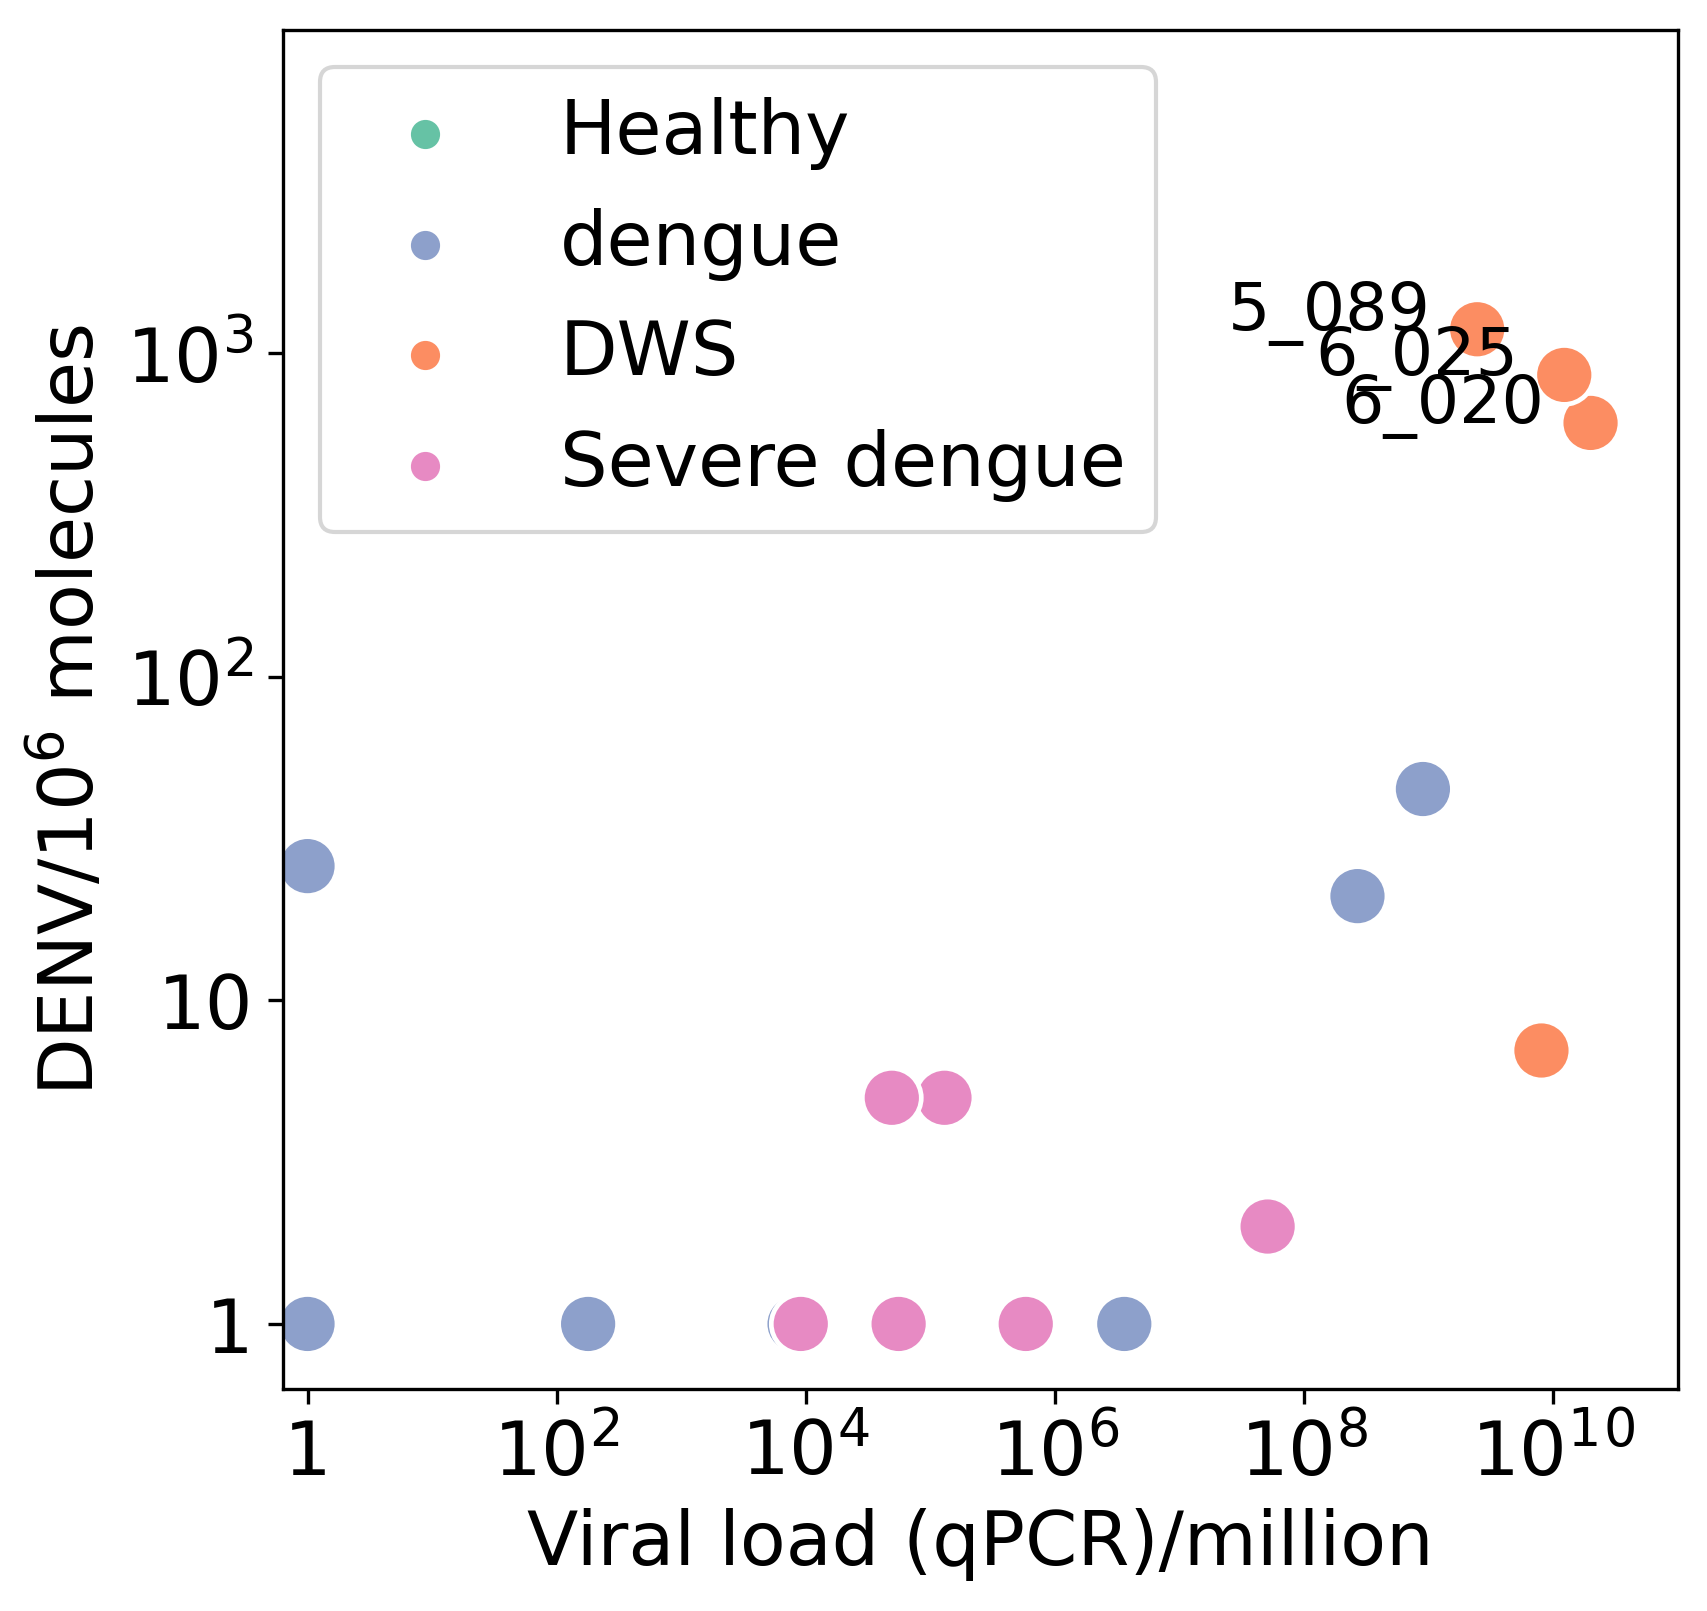

In [62]:
rcParams['figure.figsize']=(6,6)
rcParams['font.size']=18
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
cmap=sns.color_palette('Set2', 4)
sns.scatterplot(data=df, x='Viral load (qPCR)', y='DENV molecules', hue='Condition', 
            hue_order=['Healthy', 'dengue', 'DWS',  'Severe dengue'],
            palette=[cmap[0], cmap[2], cmap[1], cmap[3]], s=200, ax=ax)
ax.legend(loc='upper left')
ax.set_xlabel('Viral load (qPCR)/million')
ax.set_xlim(-0.2, 11)
ax.set_xticks(range(0, 11, 2))
ax.set_xticklabels(['1', '$10^2$', '$10^4$', '$10^6$', '$10^8$', '$10^1$'+'$^0$'])
ax.set_ylim(-0.2, 4)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['1', '10', '$10^2$', '$10^3$'])
ax.set_ylabel('DENV/10$^6$ molecules')

from adjustText import adjust_text

# texts = [ax.text(xi, yi, name[:5]) 
#          for xi, yi, name in zip(x.loc[top3]['viral_load_qpcr']-2, y.loc[top3]['DENV_reads'], top3)]
# adjust_text(texts)

for xi, yi, name in zip(x.loc[top3]['viral_load_qpcr']-2, y.loc[top3]['DENV_reads'], top3):
    ax.text(xi, yi, name[:5], fontsize=16)
plt.savefig(save_figures + 'DENV_molecules_vs_viral_load.png')
plt.savefig(save_figures + 'DENV_molecules_vs_viral_load.pdf')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


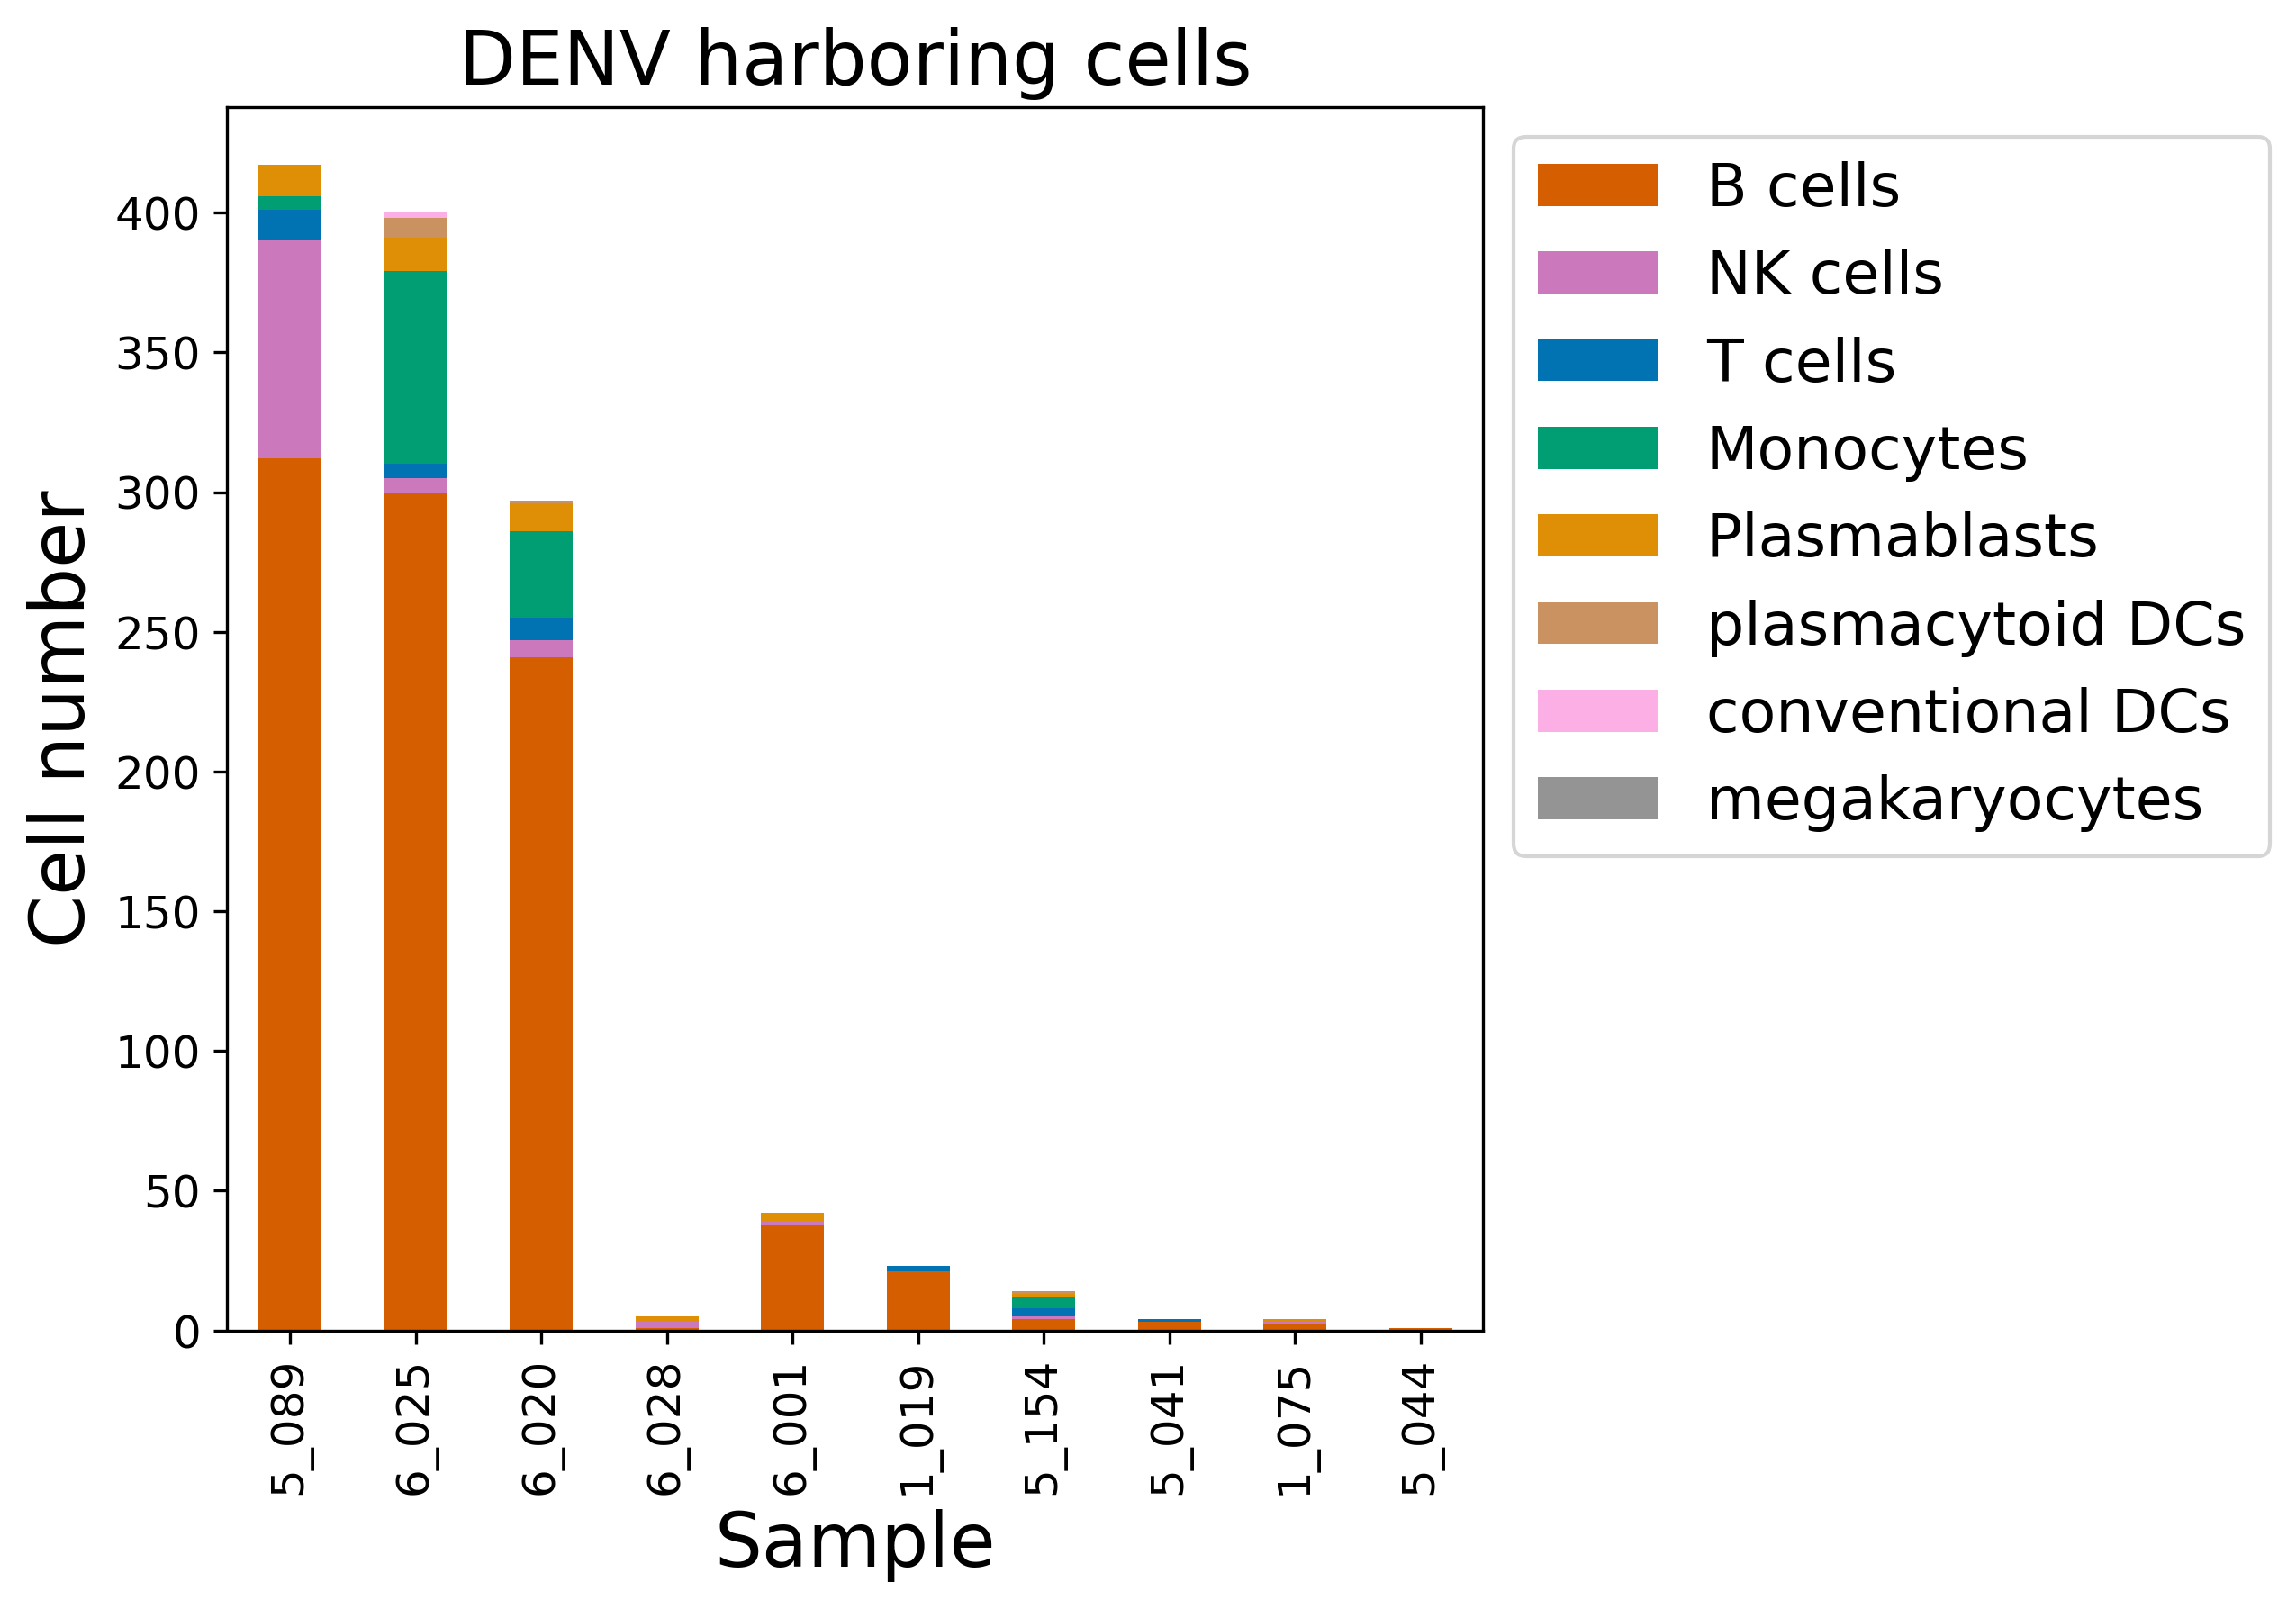

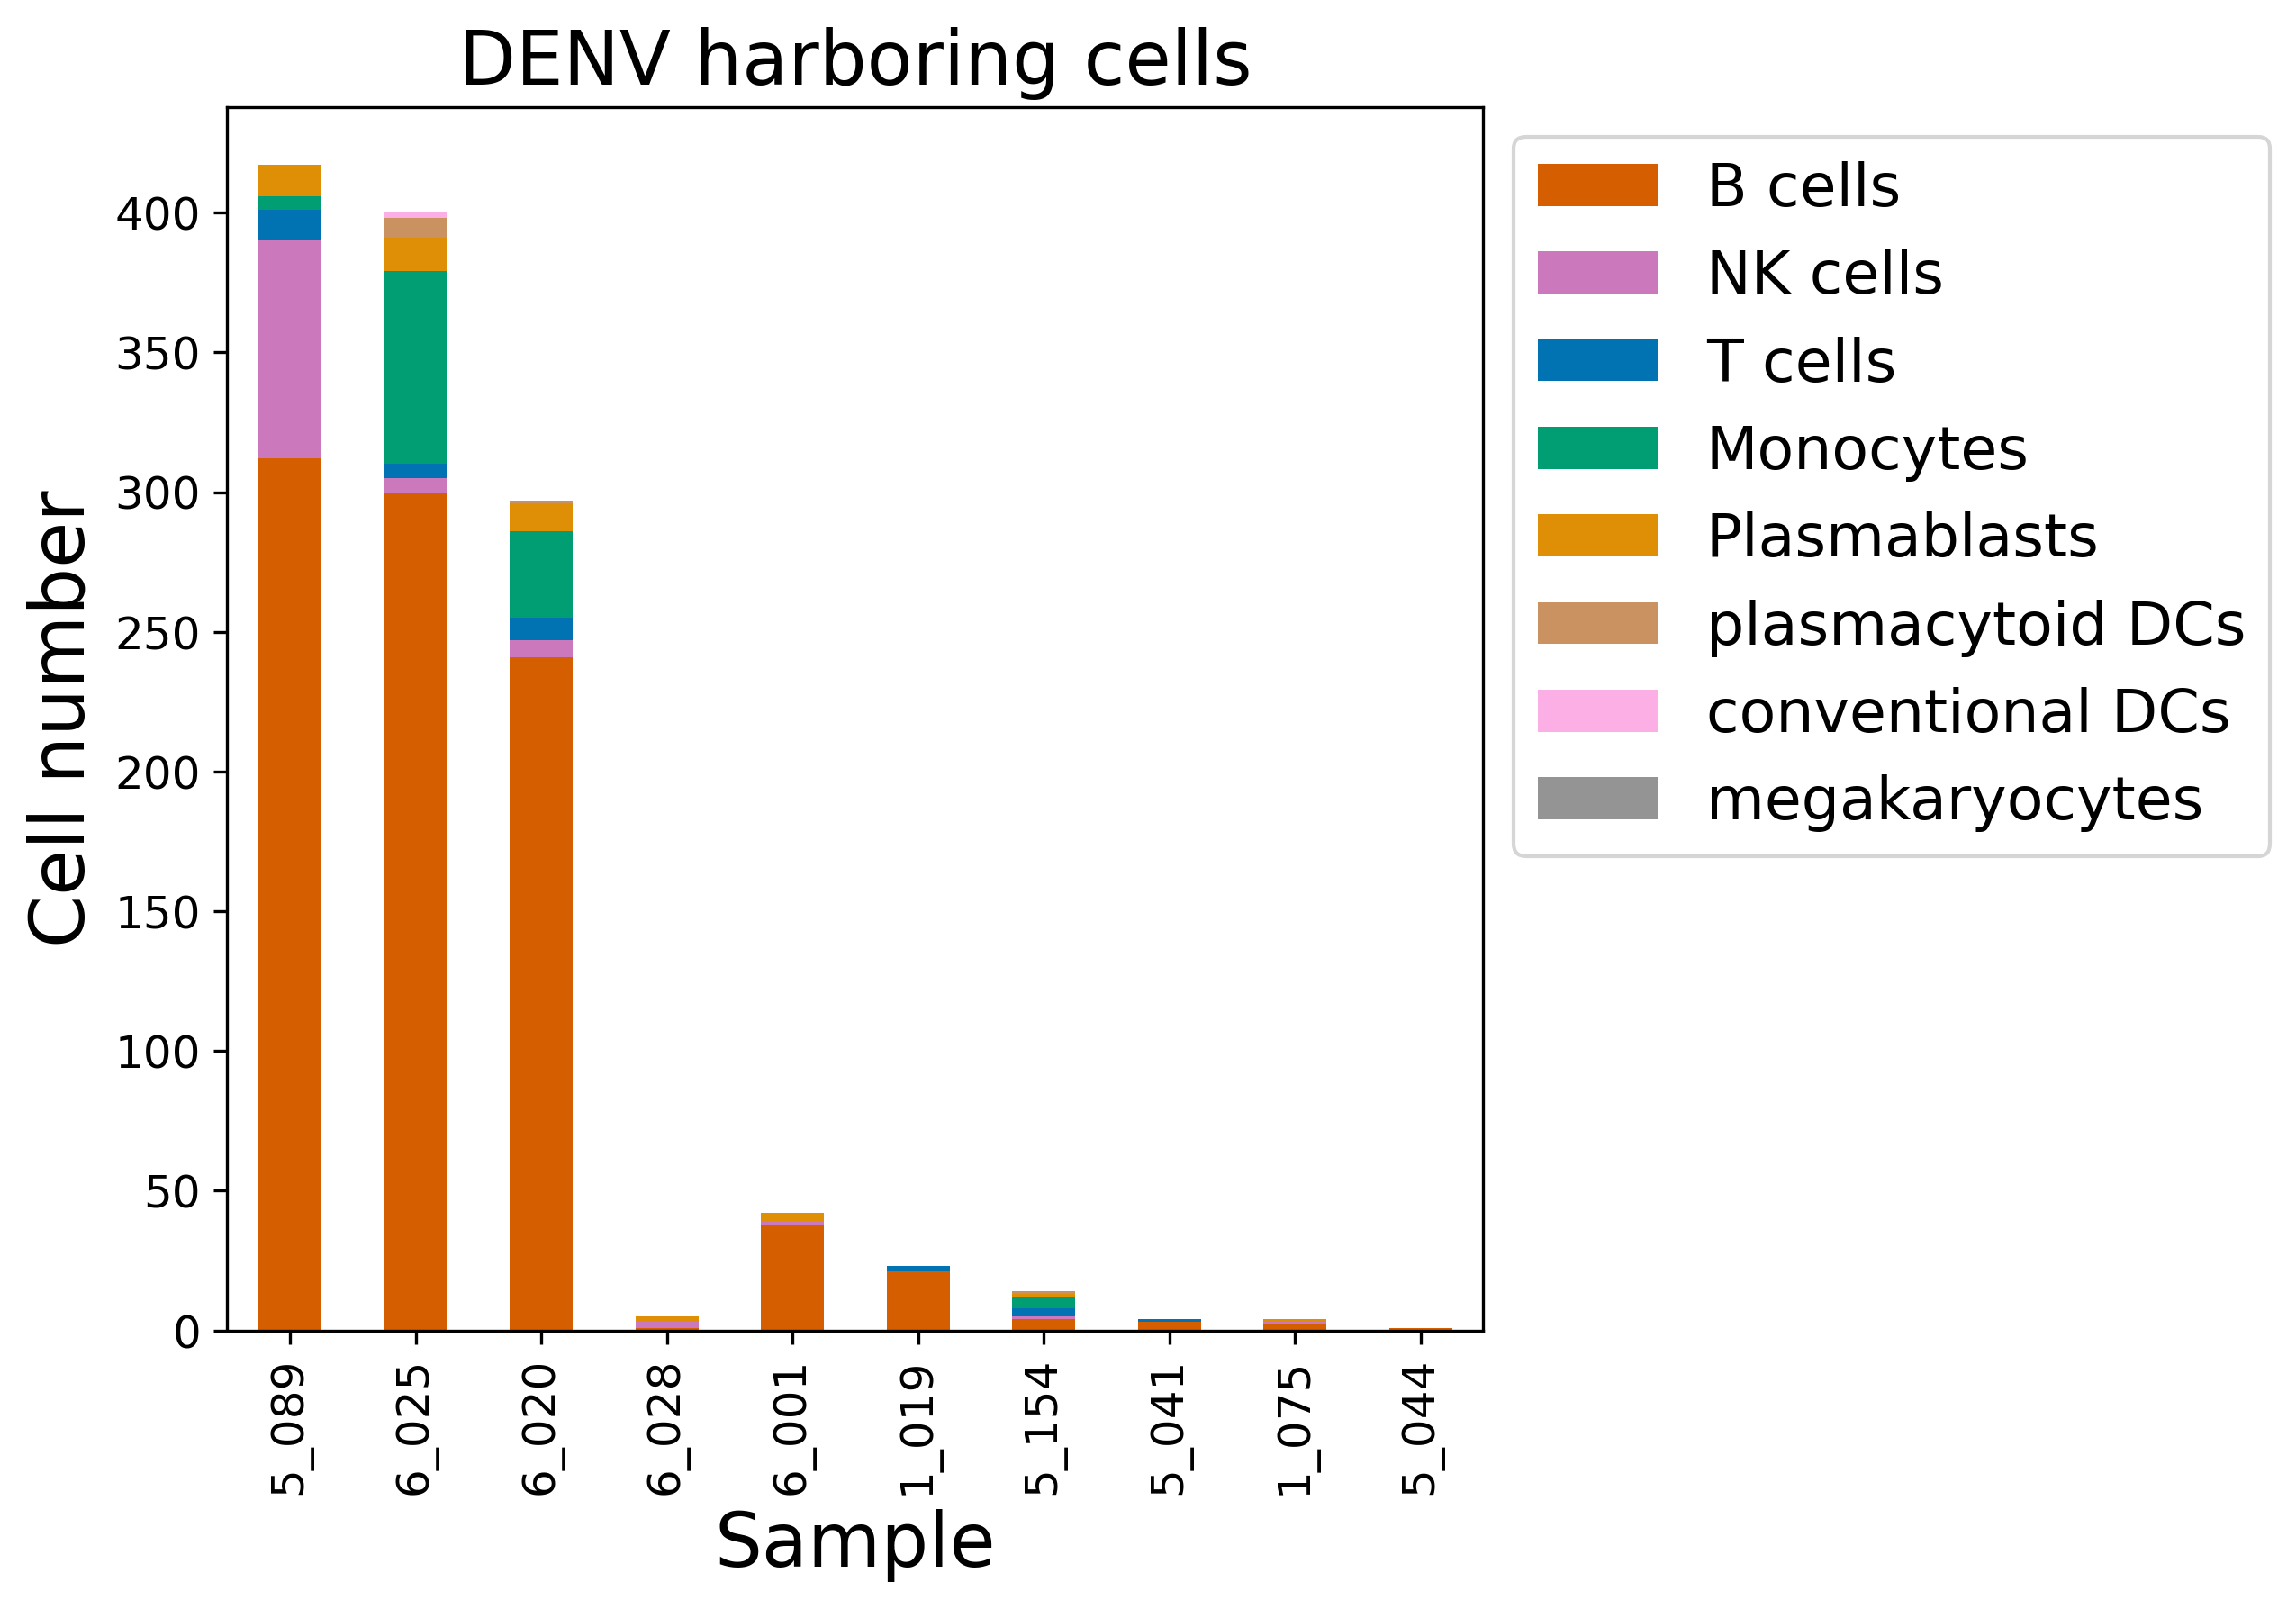

In [197]:
#calculating the numbers of VHC in each cell type and plot, Supplementary
df_info = info_df(adata_kid, 'cell_type_new')

name_1 = 'stackbar.png'
name_2 = 'stackbar.pdf'
stackplot(df_info, 'cell_type_new', save_figures, name_1)
stackplot(df_info, 'cell_type_new', save_figures, name_2)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


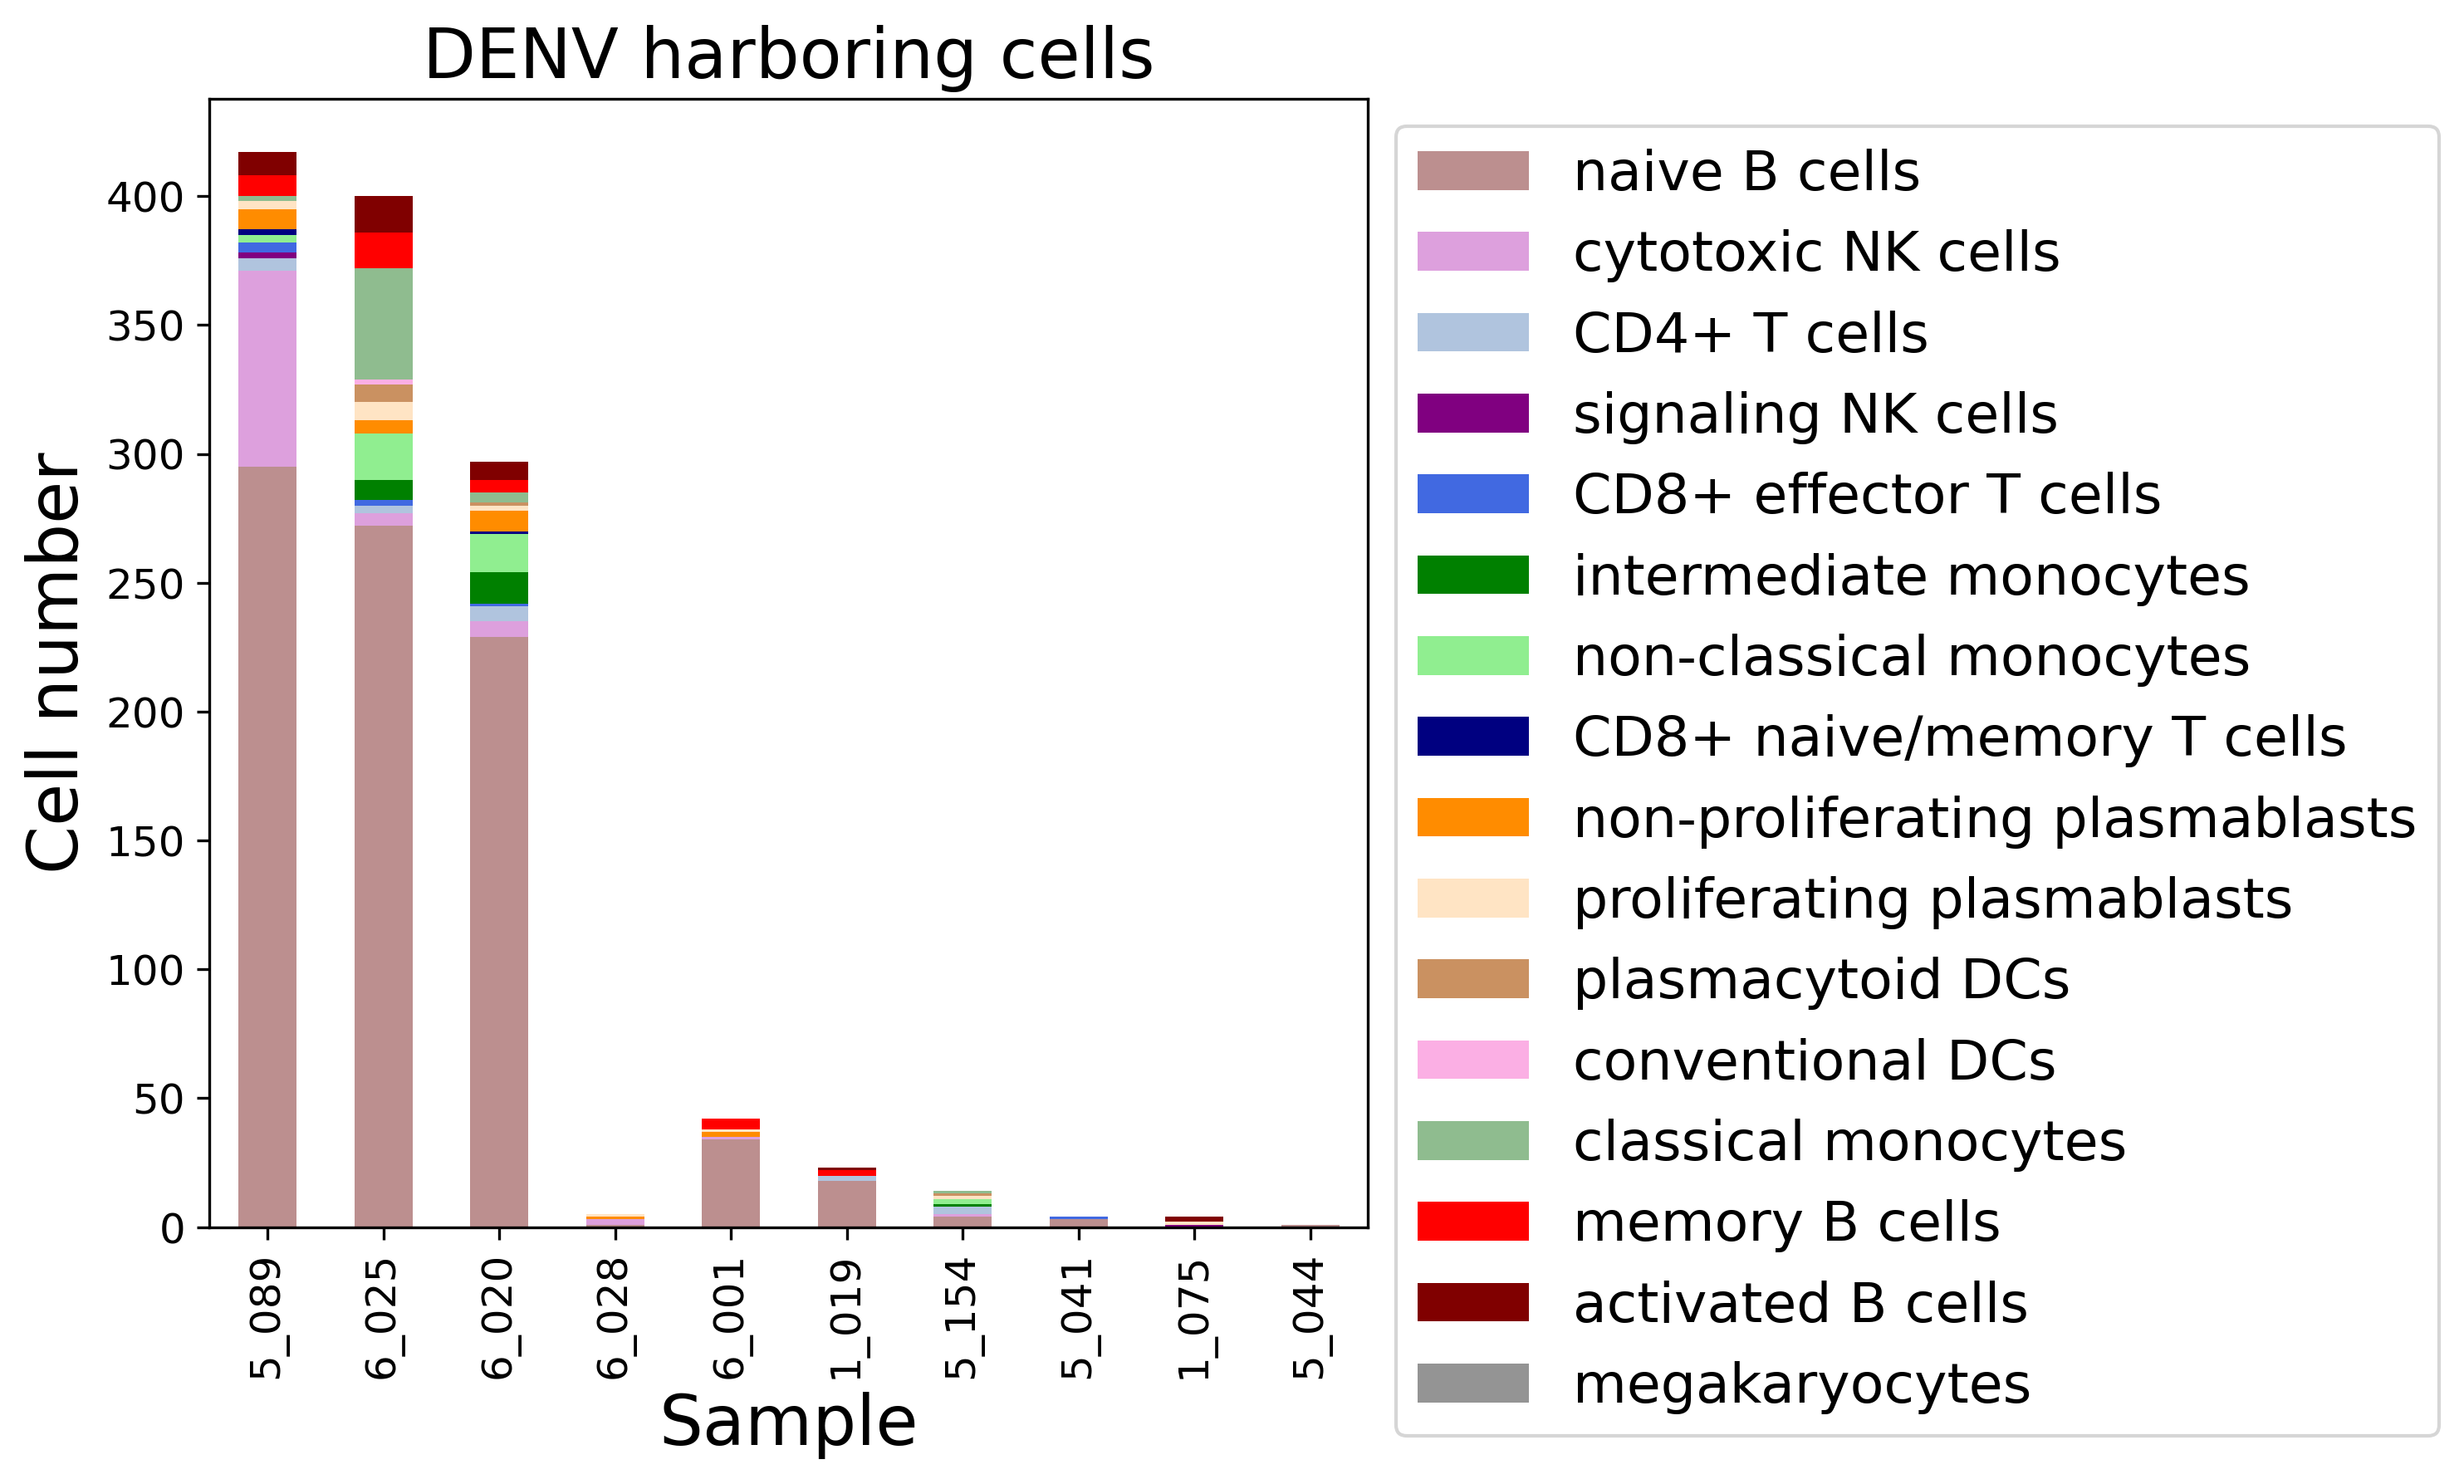

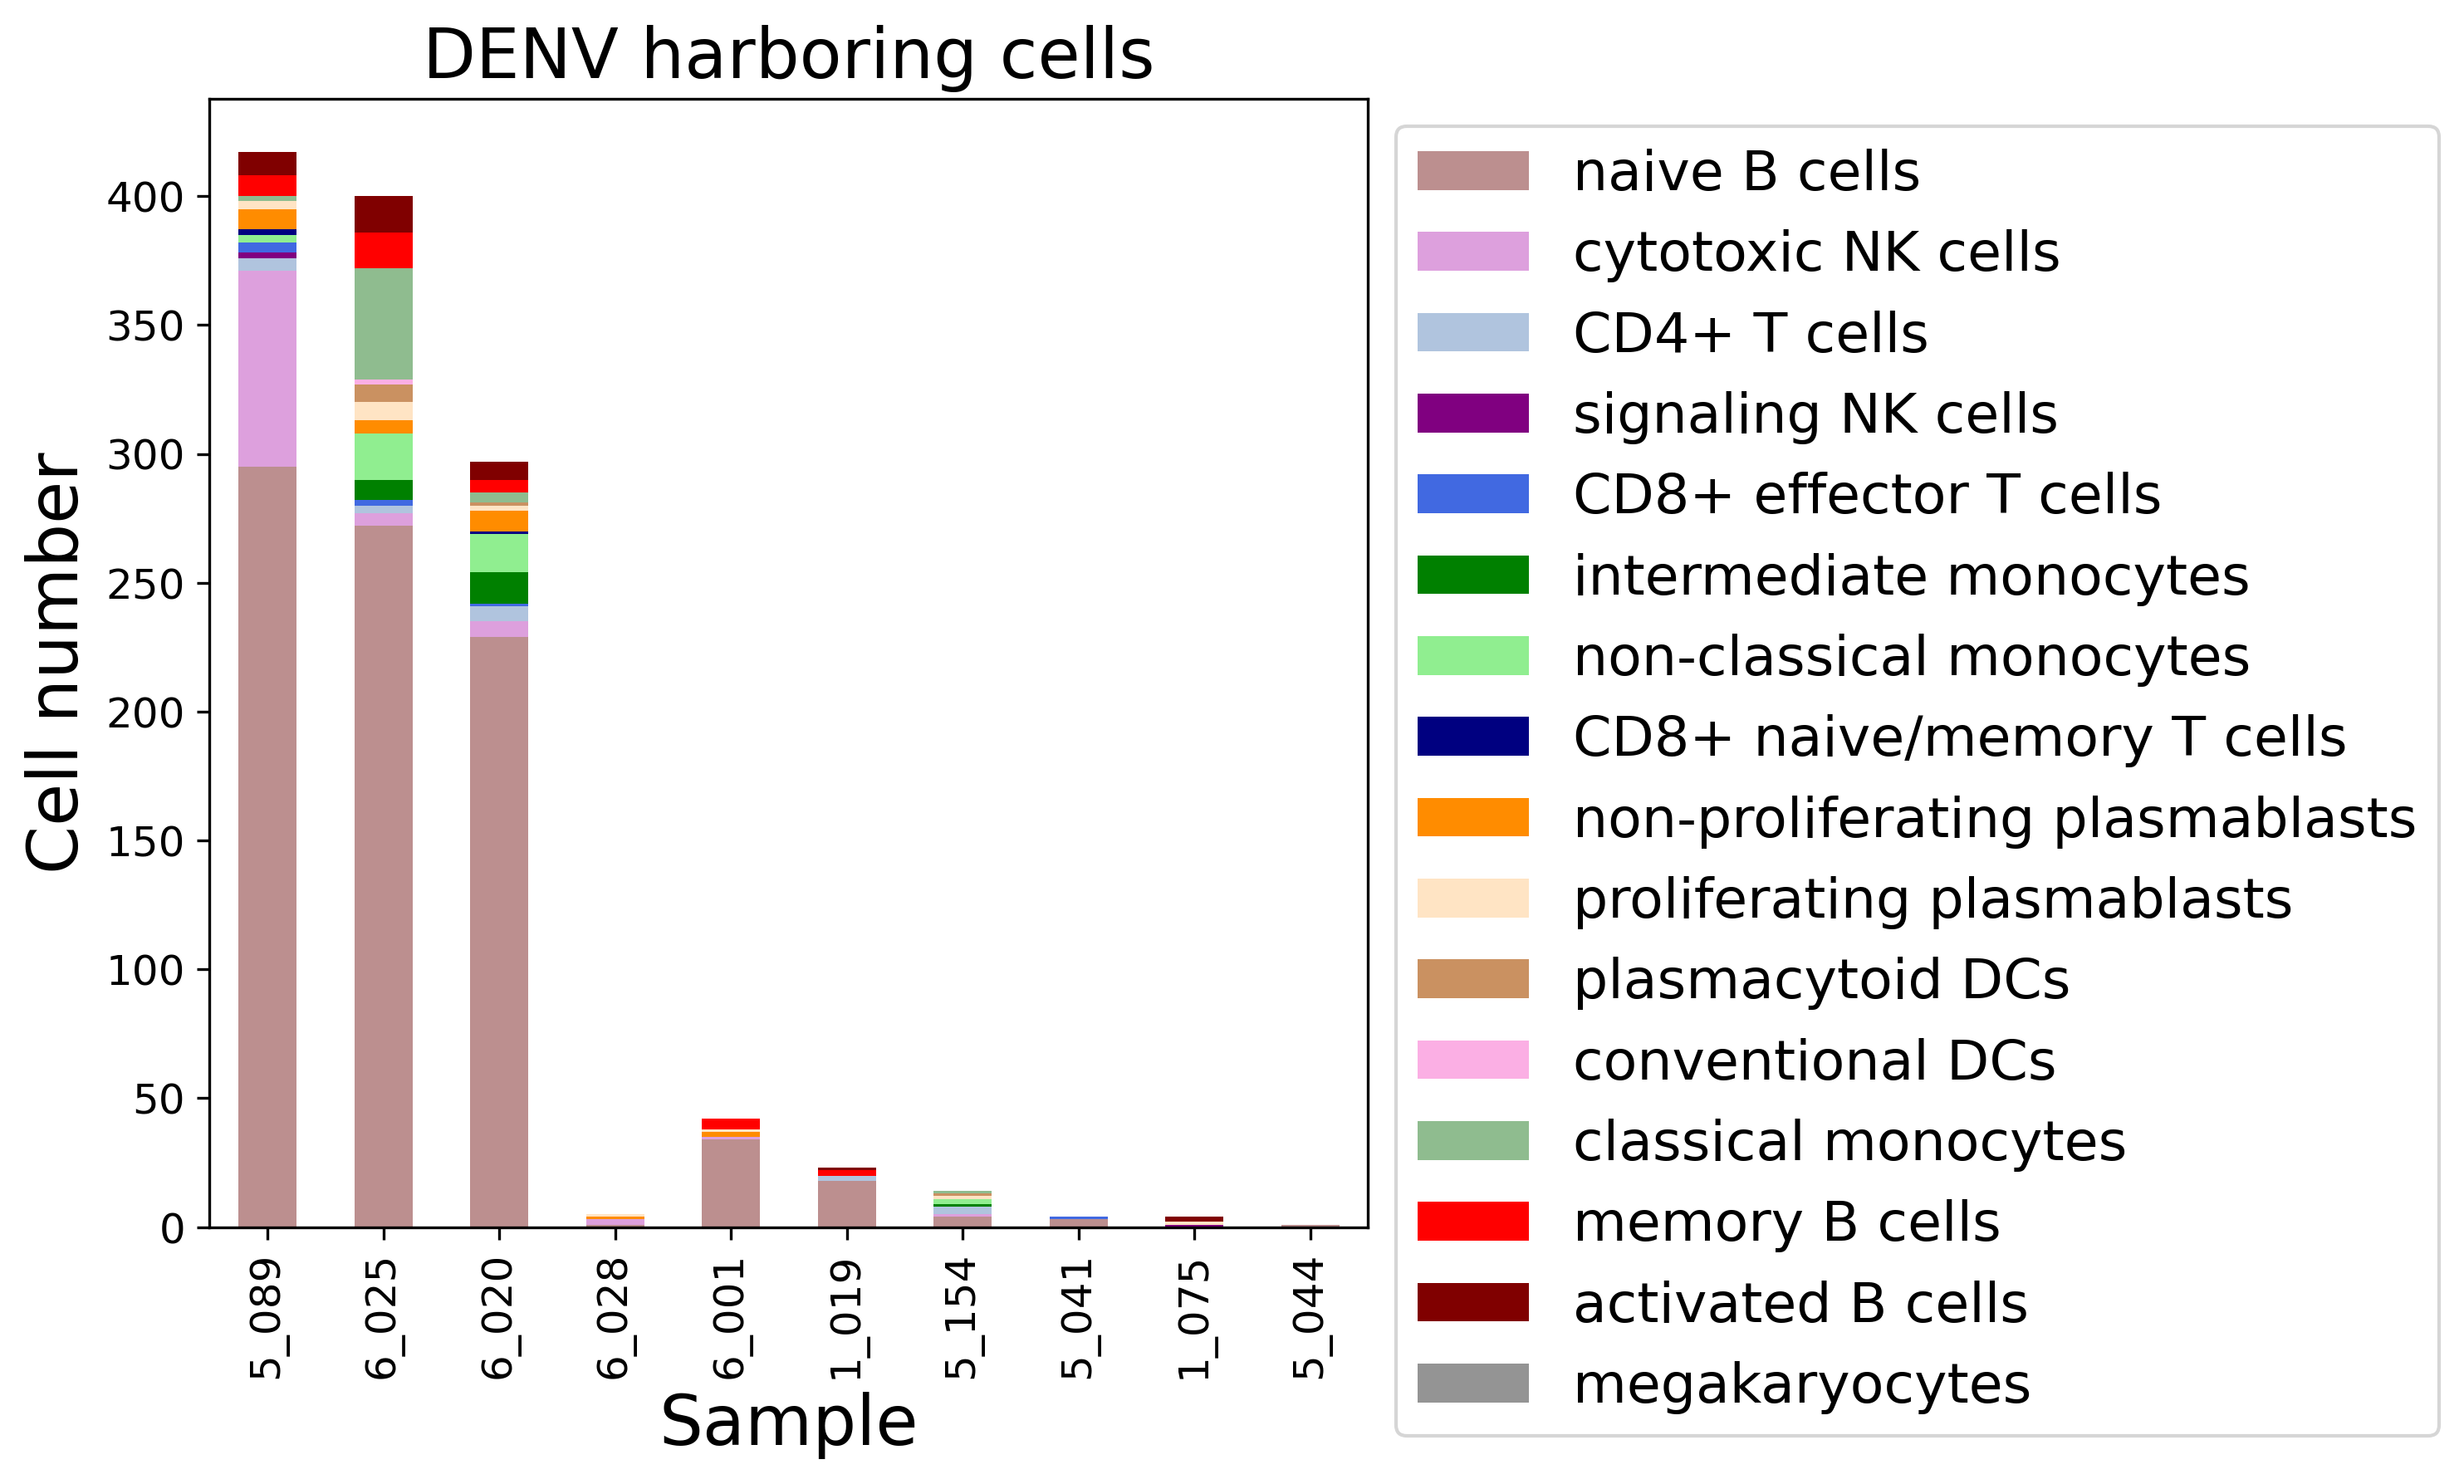

In [198]:
df_cst_info = info_df(adata_kid, 'cell_subtype_new')

name_1 = 'stackbar_cst.png'
name_2 = 'stackbar_cst.pdf'
stackplot(df_cst_info, 'cell_subtype_new', save_figures, name_1)
stackplot(df_cst_info, 'cell_subtype_new', save_figures, name_2)

In [14]:
ind = np.in1d(adata_kid.obs.ID, ['5_089_01', '6_025_01', '6_020_01'])
adata_kid_DWS = adata_kid[ind]
adata_DENV = adata_kid_DWS[adata_kid_DWS.obs['DENV_reads'] > 0]

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 92.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 60.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3.9/site-package

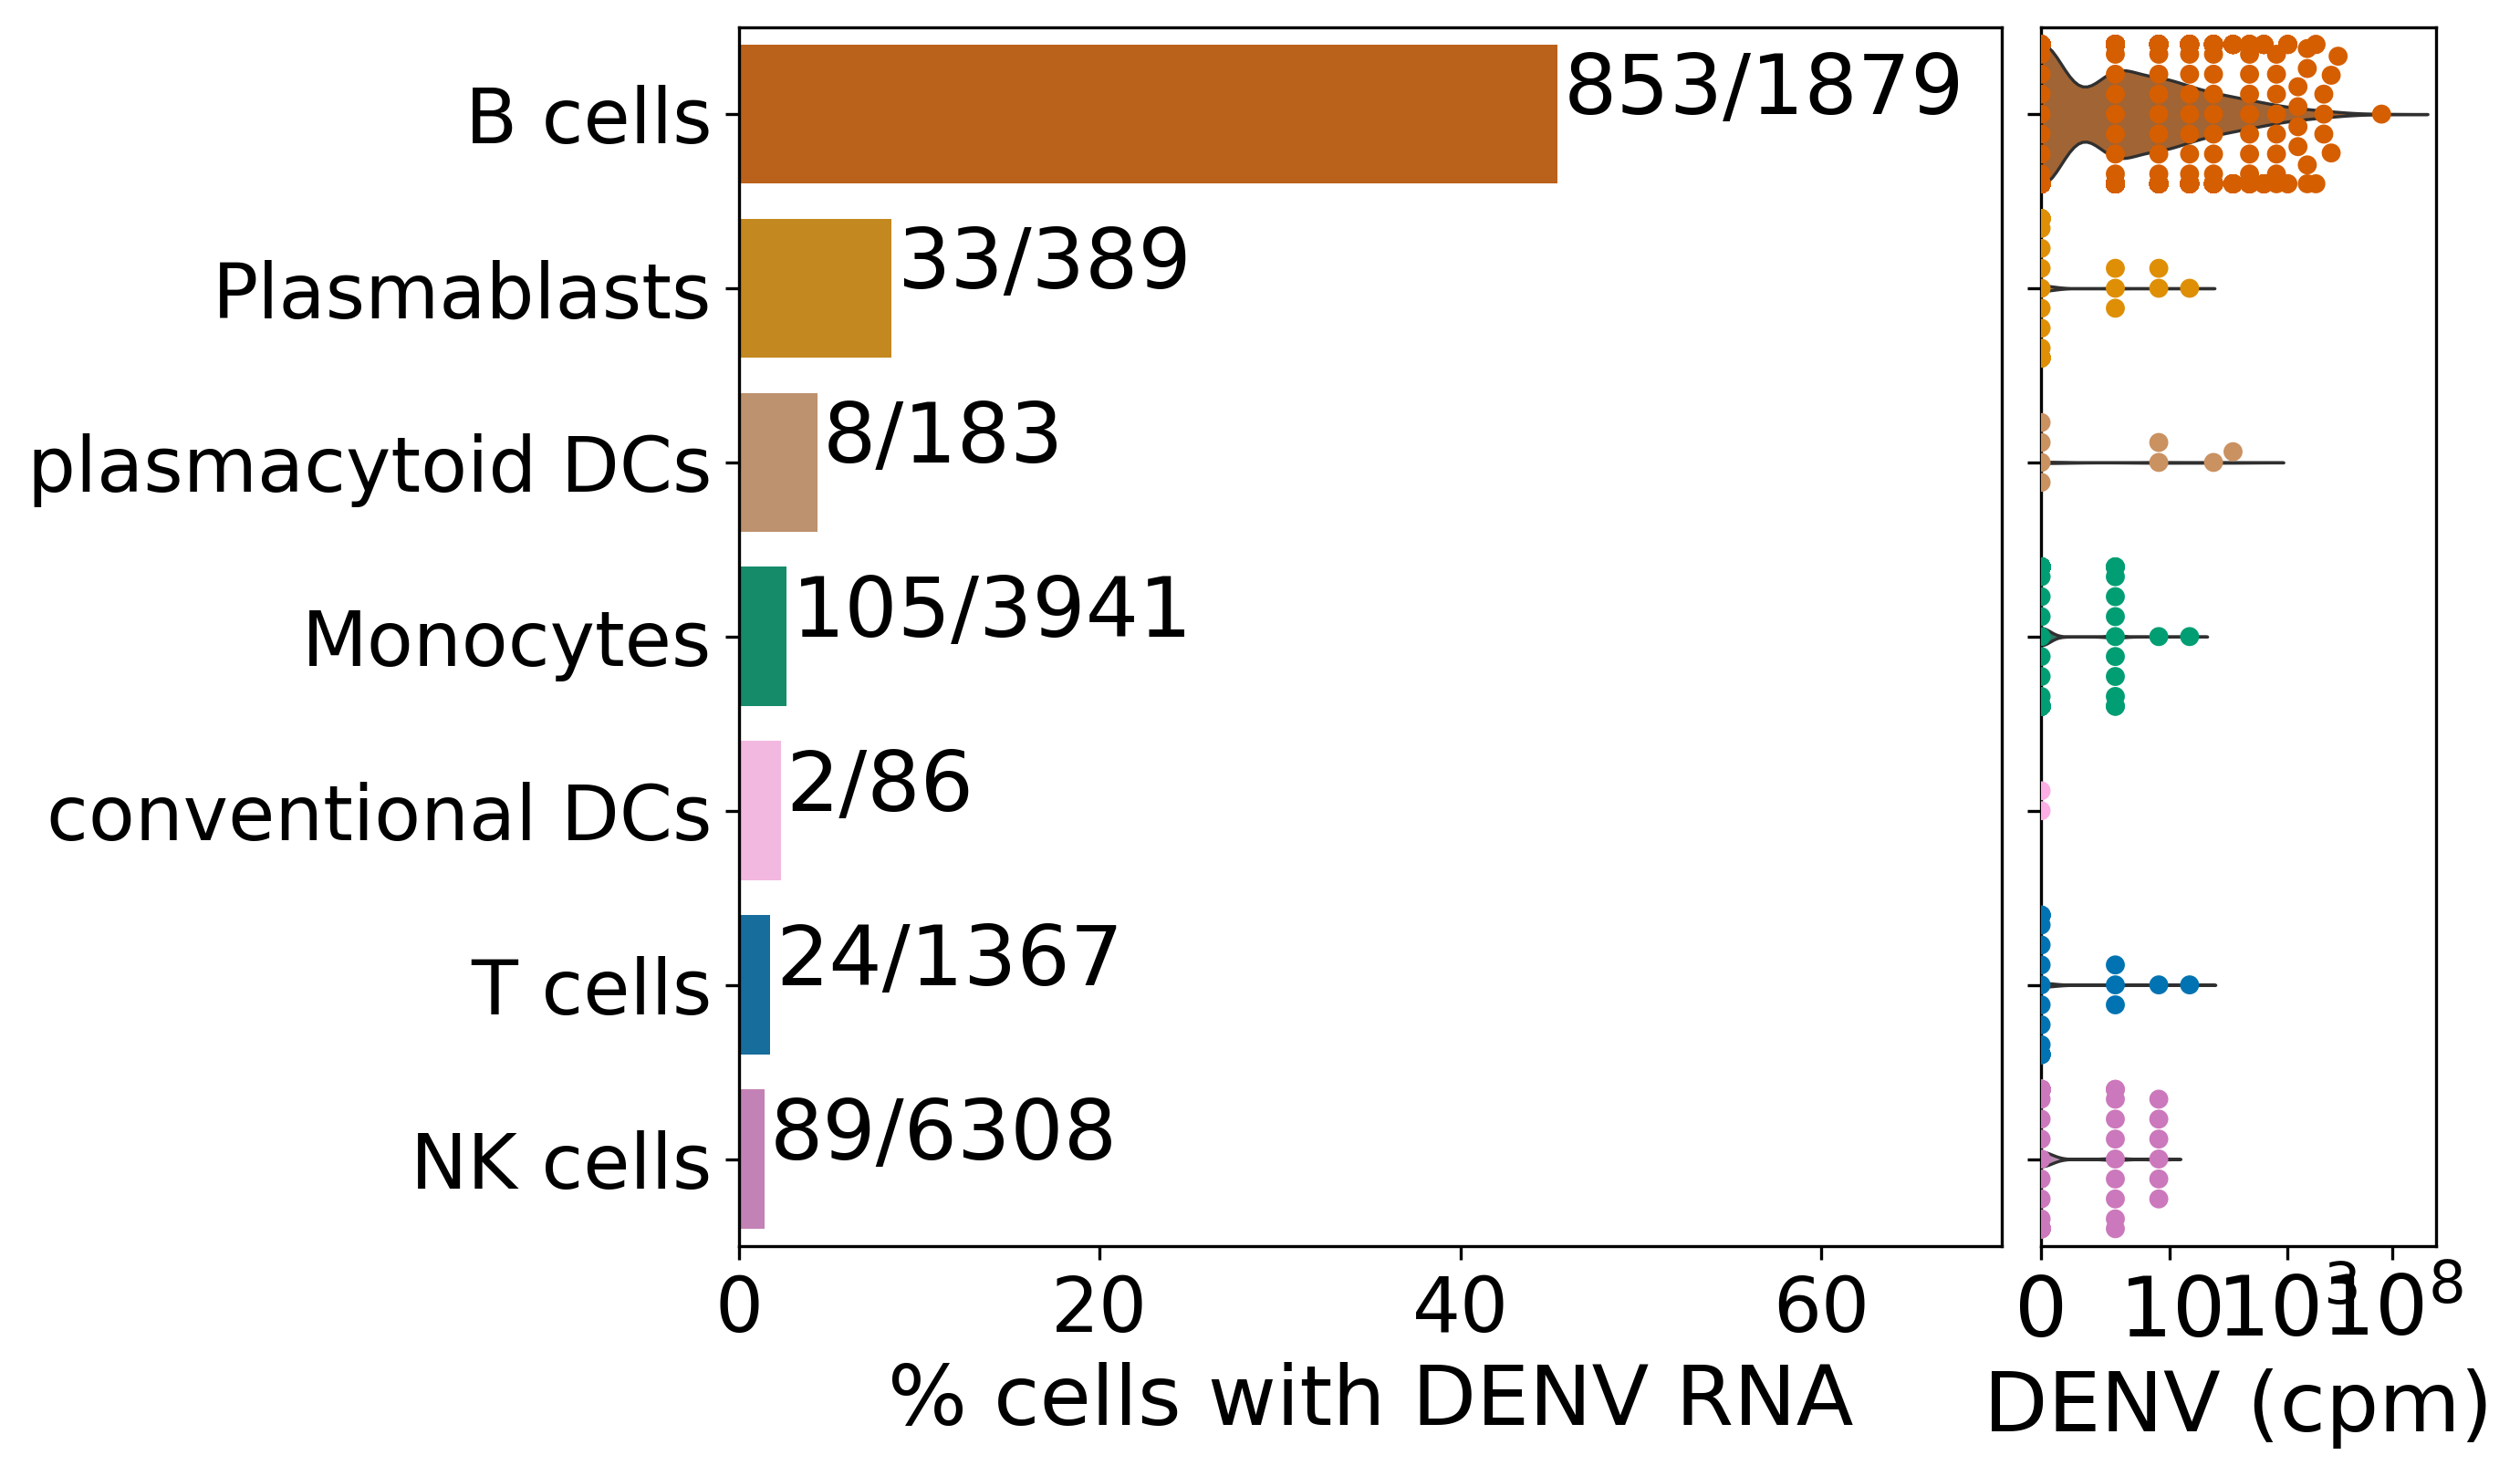

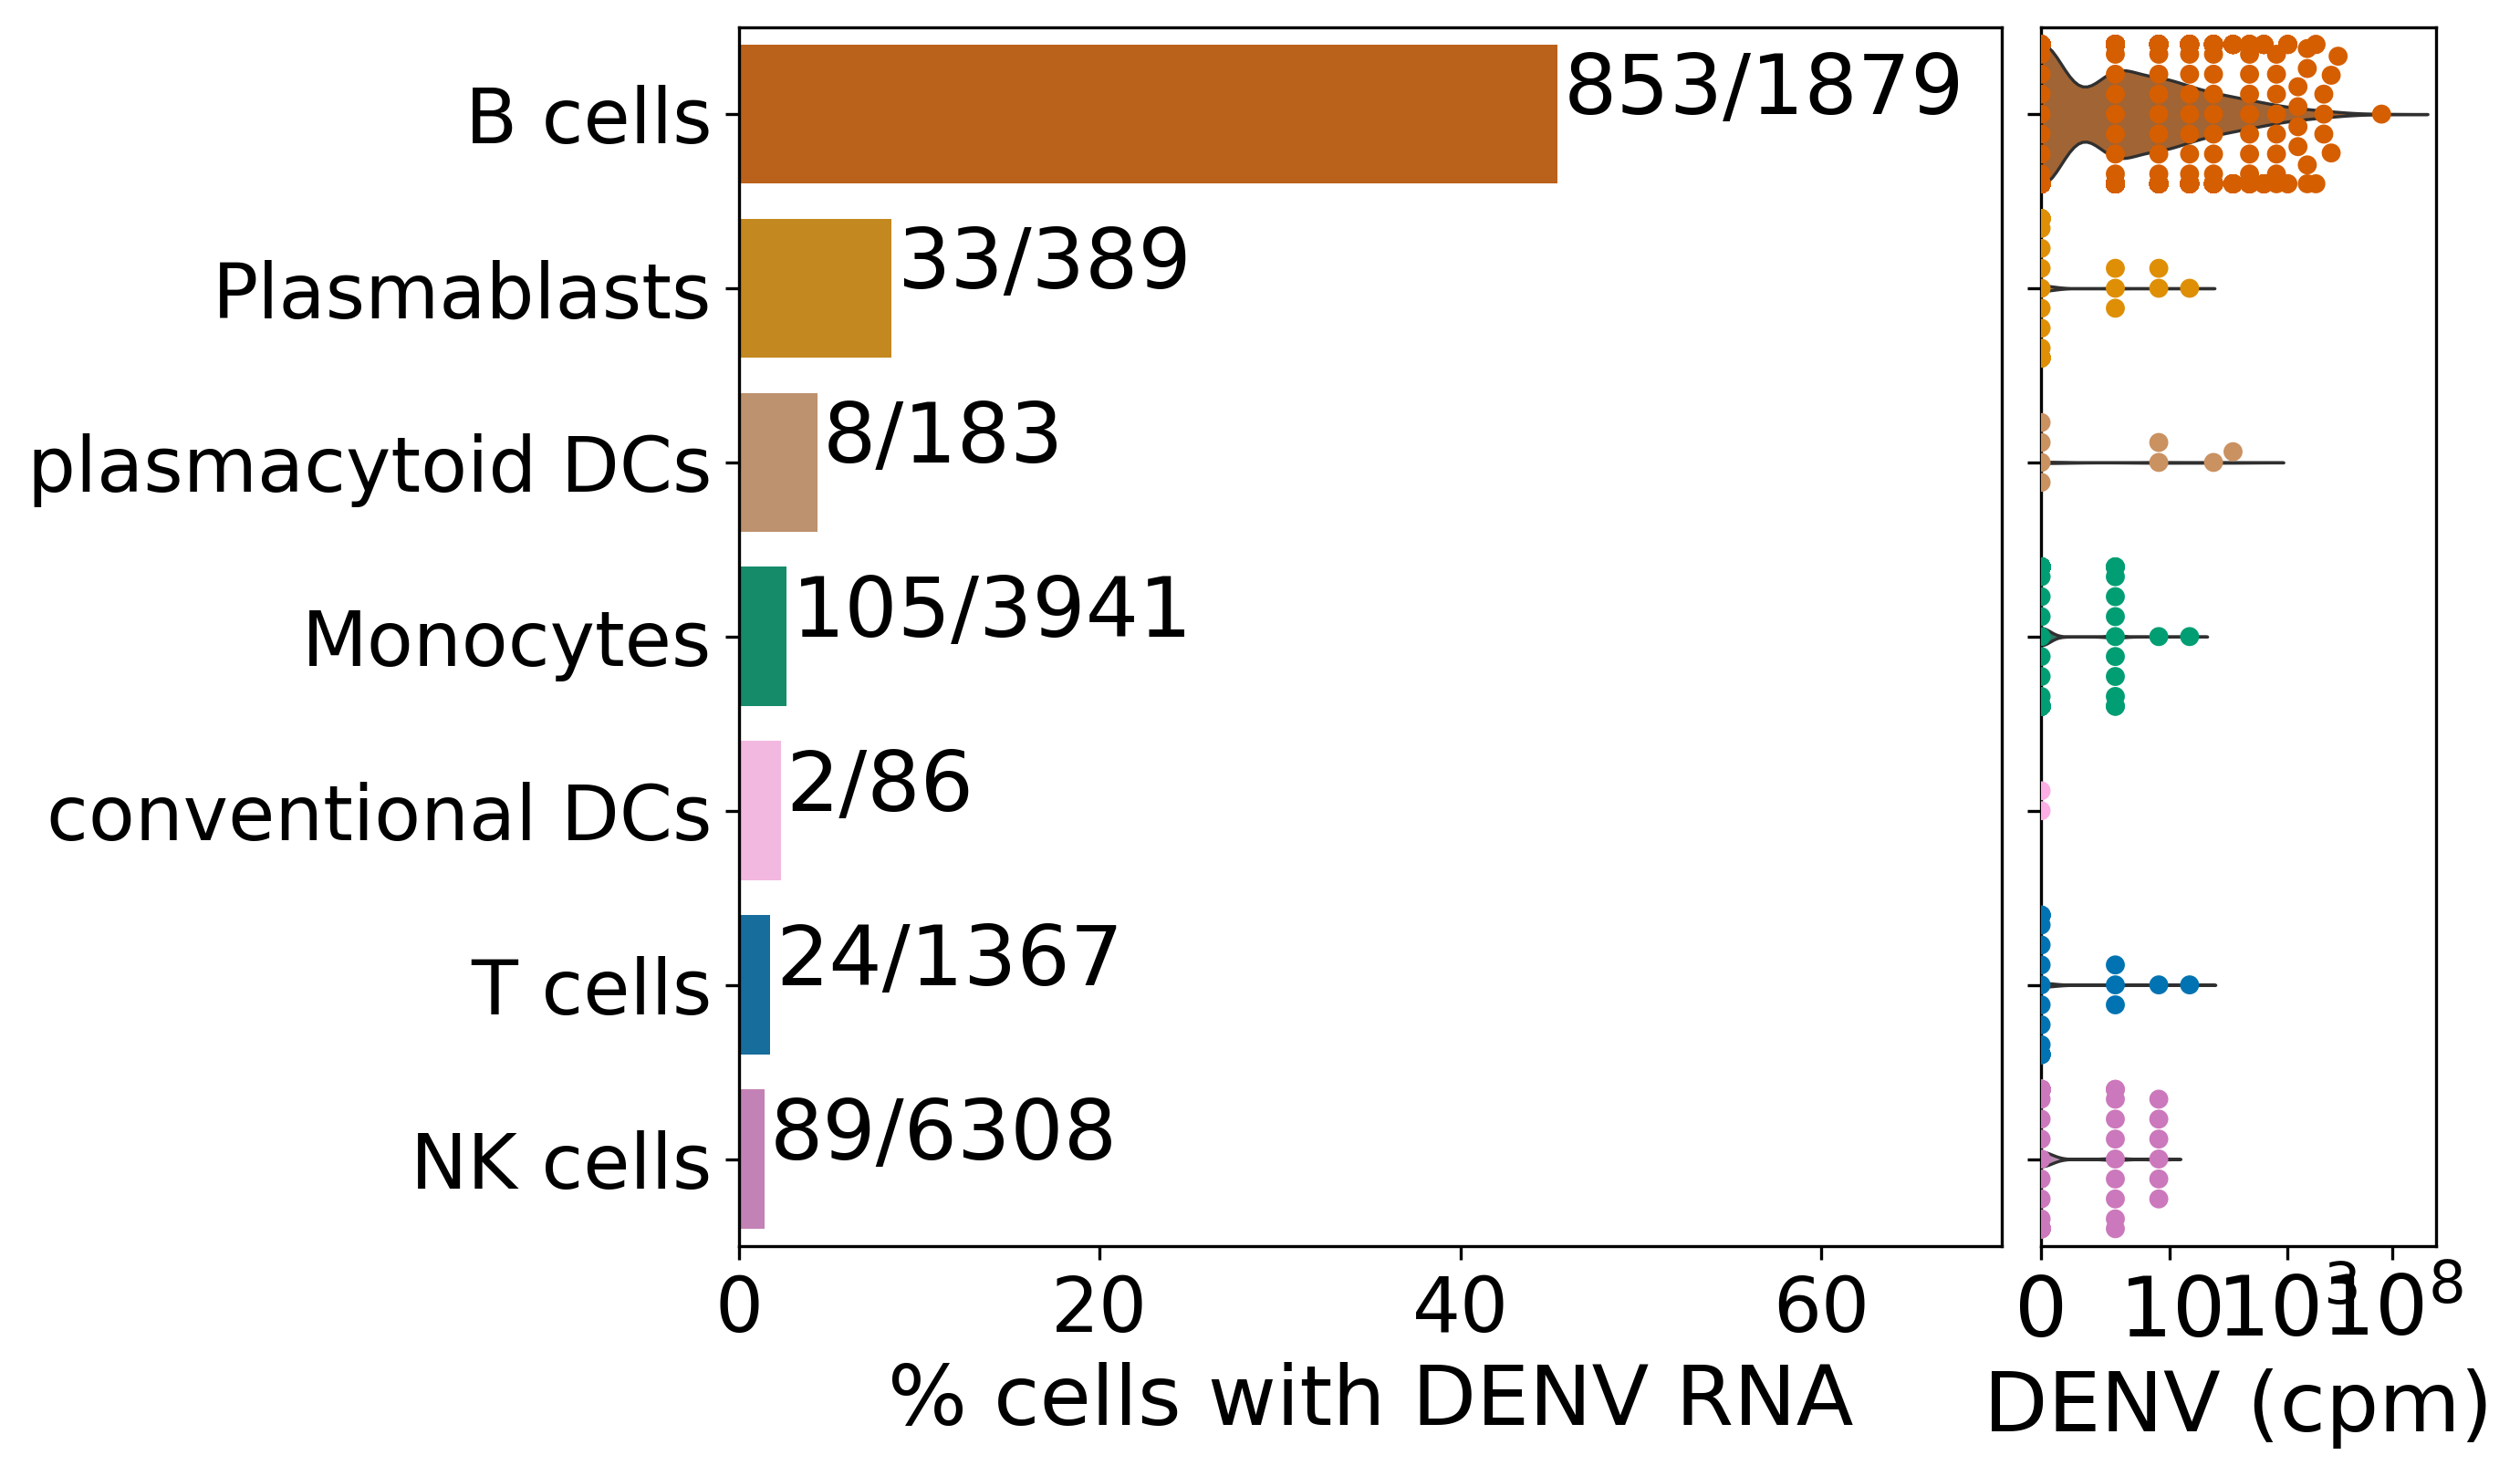

In [15]:
#For the VHC ratio panel in Figure 2B

#calculate the ratio and generate the table
df_info = info_df(adata_kid, 'cell_type_new')
df_merge = df_info_process(df_info, adata_kid, 'cell_type_new')

#plotting
fraction_violin(df_merge, adata_DENV, 'cell_type_new', save_figures, filetype='.pdf')
fraction_violin(df_merge, adata_DENV, 'cell_type_new', save_figures, filetype='.png')

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/usr/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 92.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/lib/python3.9/site-packages/seaborn/categor

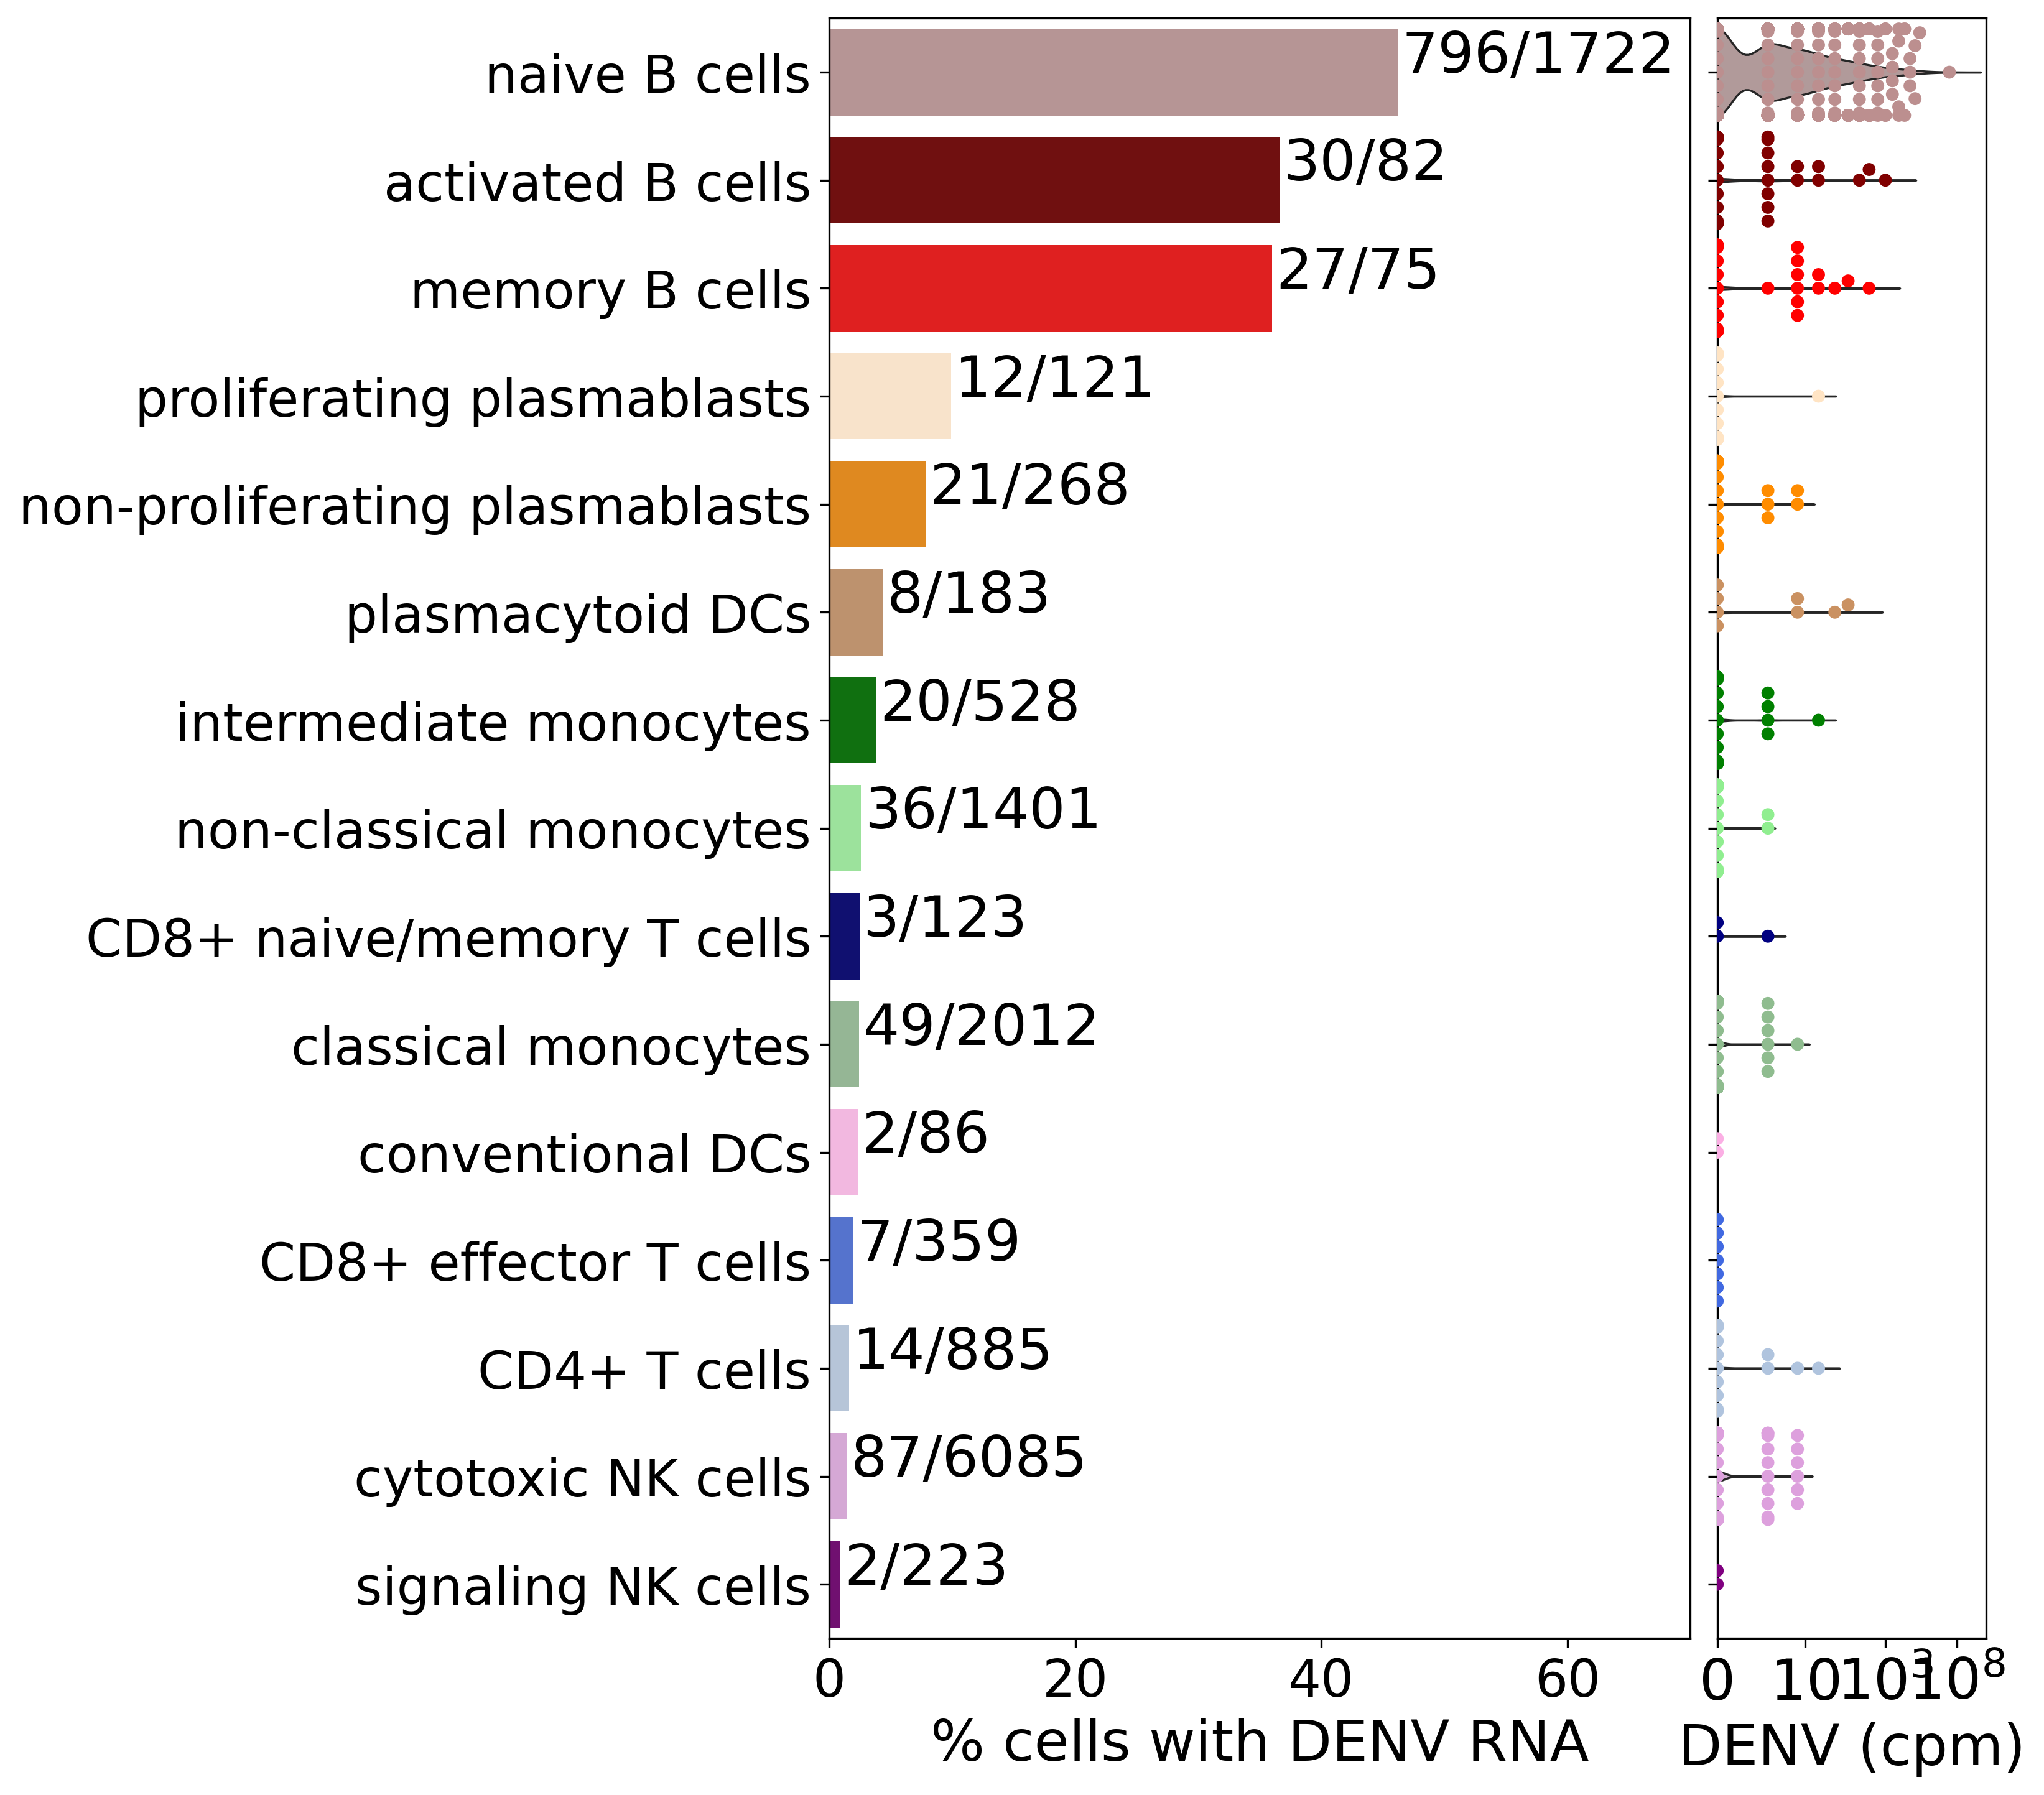

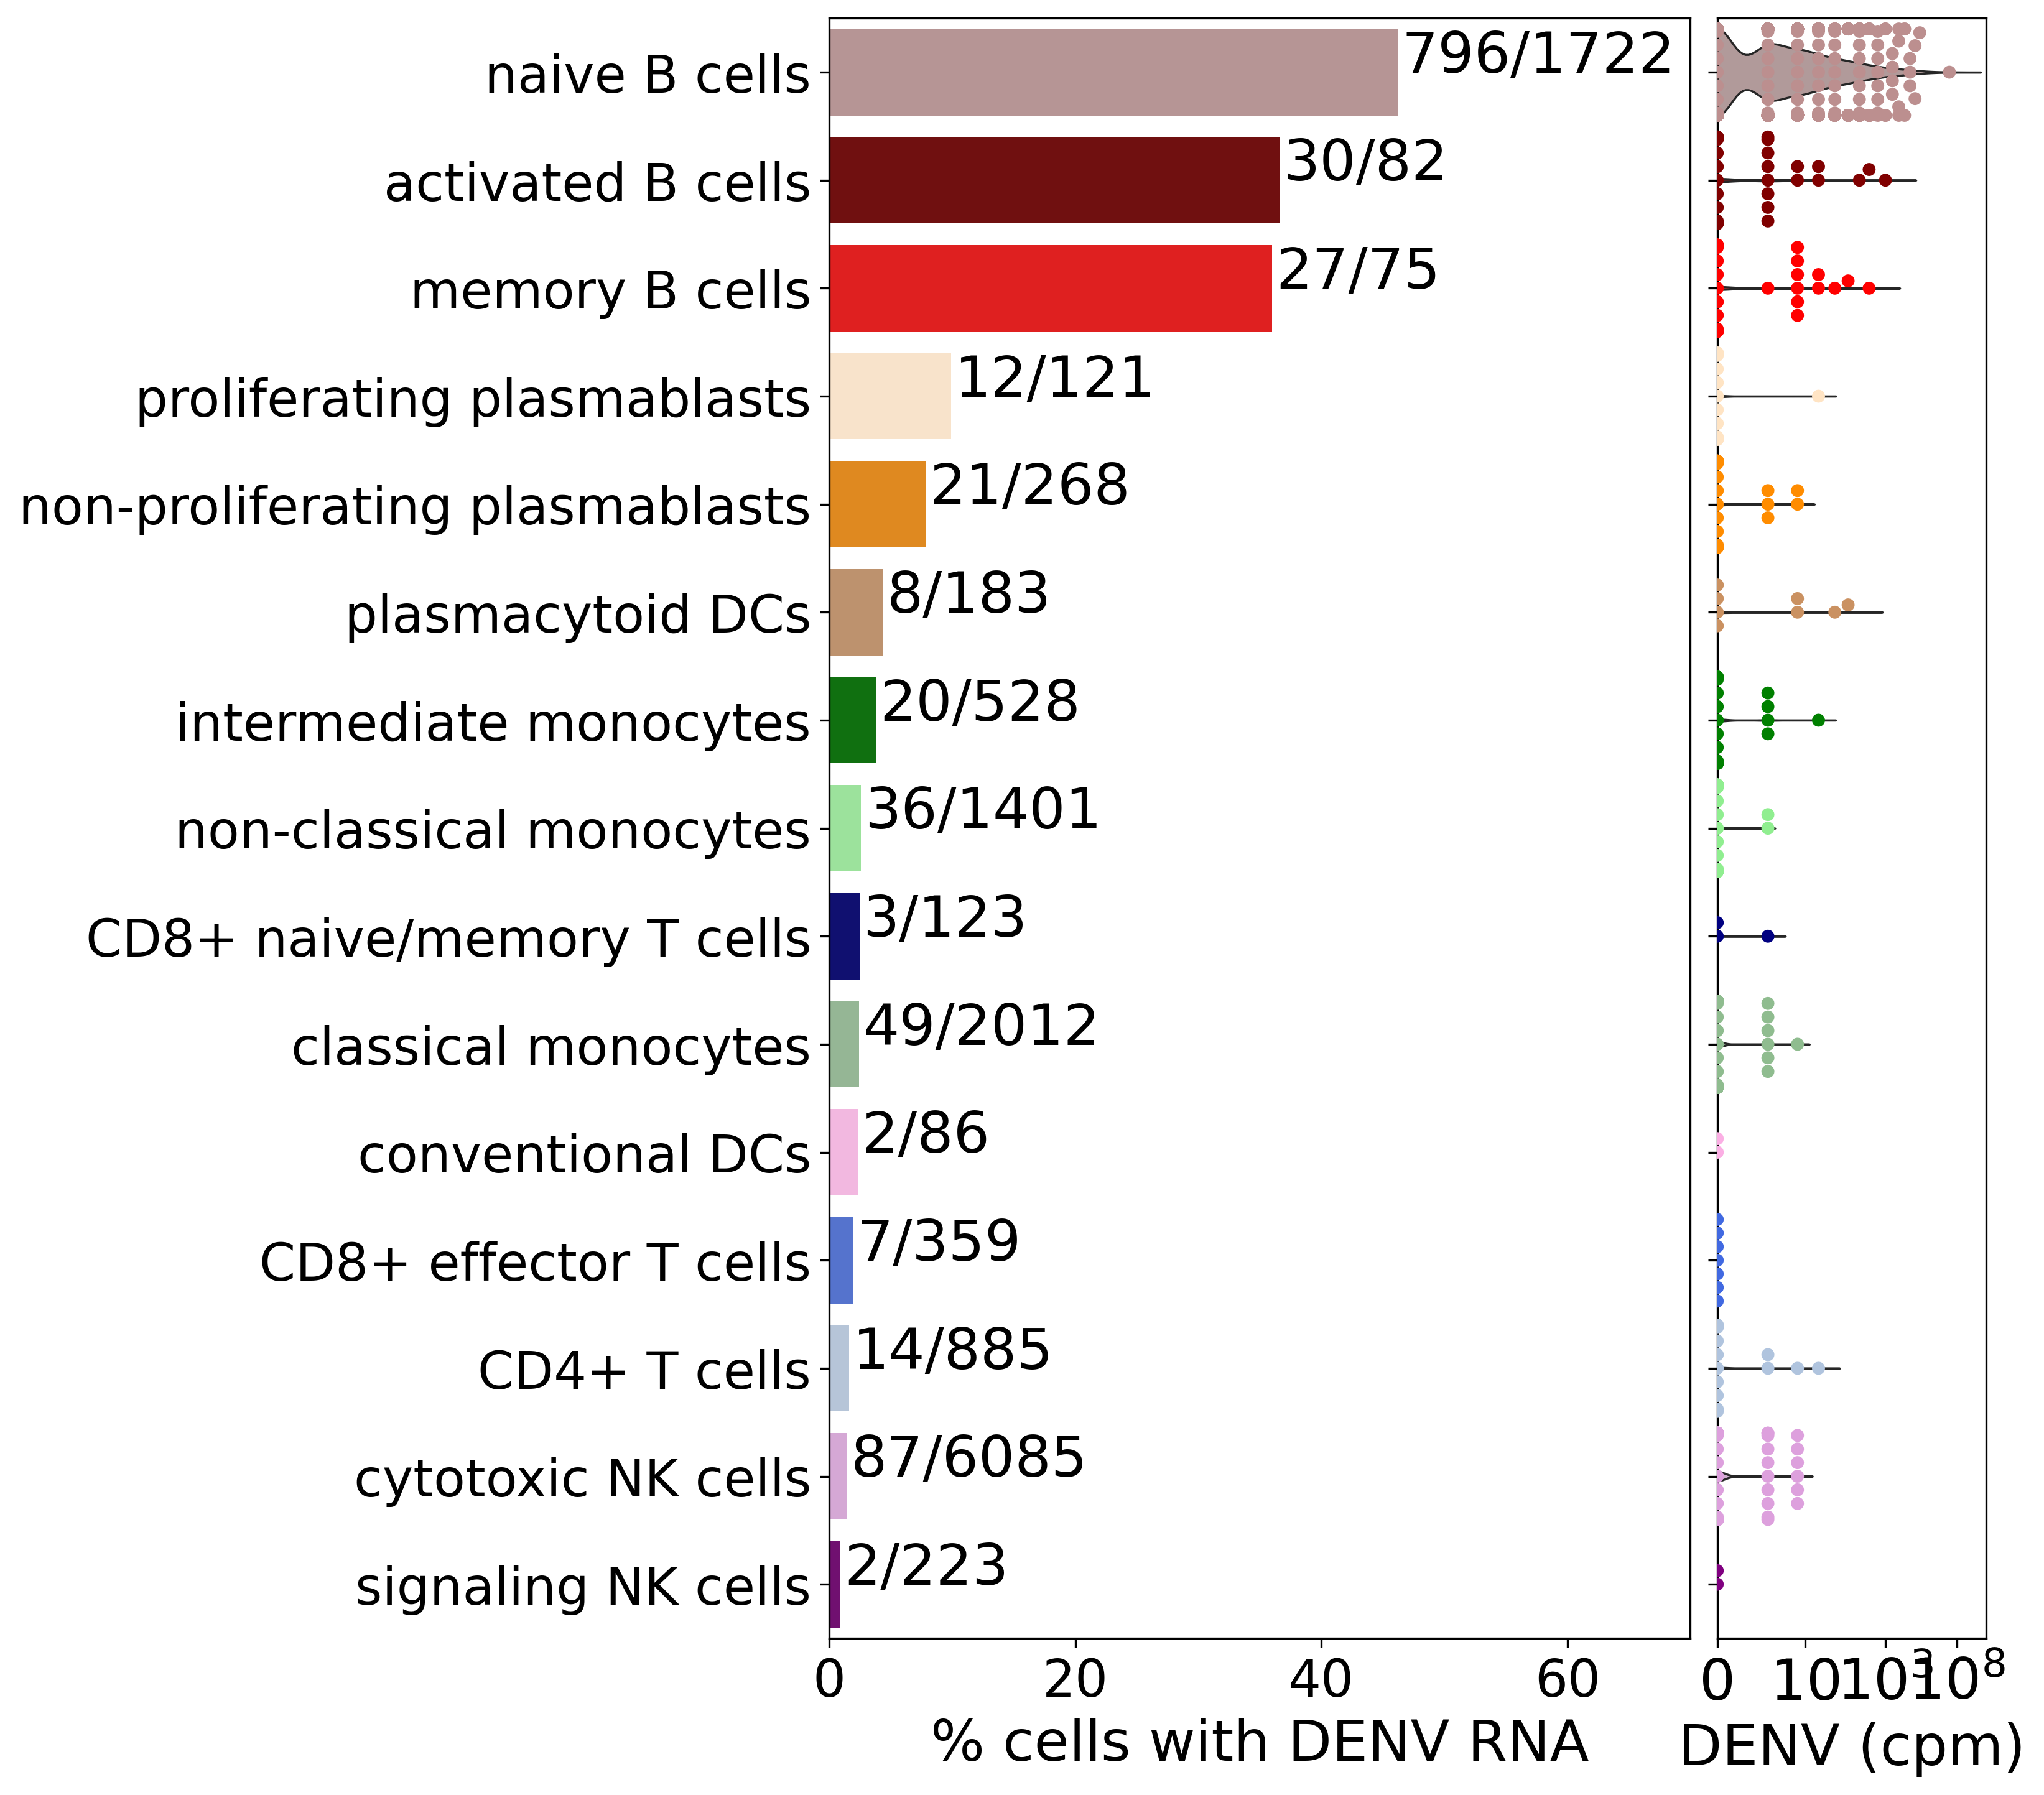

In [16]:
#For the VHC ratio panel in Figure 2B

#calculate the ratio and generate the table
df_cst_info = info_df(adata_kid, 'cell_subtype_new')
df_cst_merge = df_info_process(df_cst_info, adata_kid, 'cell_subtype_new')

#plotting
fraction_violin(df_cst_merge, adata_DENV, 'cell_subtype_new', save_figures, filetype='.pdf')
fraction_violin(df_cst_merge, adata_DENV, 'cell_subtype_new', save_figures, filetype='.png')
